* ASTER TB image
* MODIS TB image
* GOES TB image
* MODIS-ASTER difference: image & histogram
* GOES-ASTER difference: image & histogram

In [1]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

Set plot text sizes

In [3]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


Define functions

In [4]:
def summary_stats(a, b):
    '''Compute summary statistics for the difference between two sets.
    Input two flattened (1-D) arrays with NaN values removed'''
    
    # remove nan values
    a = a[np.isnan(a)==False]
    b = b[np.isnan(b)==False]
    
    # for difference stats
    diff = b - a
    
    # for linear regression stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        #'diff' : diff ,
        'n' : len(diff) ,
        'mean_diff' : np.nanmean( diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        'slope' : slope,
        'intercept' : intercept,
        'r_value' : r_value,
        'p_value' : p_value,
        'std_err' : std_err
        }
    
    return summary_stats_dict

---
Read in the ground based data timeseries for Gaylor Pit and CUES sites

In [5]:
#tuol_df = pd.read_pickle('data/goes-tuolumne_2017-2020.pkl')
#tuol_df['timeUTC'] = tuol_df.index + pd.Timedelta(hours=8)
#tuol_df.set_index('timeUTC',inplace=True)
#tuol_ds = tuol_df.to_xarray().squeeze()

In [6]:
#cues_df = pd.read_pickle('data/goes-cues_2017-2020.pkl')
#cues_df['timeUTC'] = cues_df.index + pd.Timedelta(hours=8)
#cues_df.set_index('timeUTC',inplace=True)
#cues_ds = cues_df.to_xarray().squeeze()

Set up working area geometry

In [7]:
# Larger area around Tuolumne further south and east to include Mammoth
(utm_e_UL, utm_n_UL) = 282500, 4205000
(utm_e_UR, utm_n_UR) = 305000, 4205000
(utm_e_LR, utm_n_LR) = 327500, 4160000
(utm_e_LL, utm_n_LL) = 305000, 4160000

geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_e_UL, utm_n_UL],
            [utm_e_UR, utm_n_UR],
            [utm_e_LR, utm_n_LR],
            [utm_e_LL, utm_n_LL]
        ]]
    }
]

Find datasets

In [8]:
#filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_orthorectified.nc')
filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_original.nc')

Open all datasets

In [9]:
ds = xr.open_mfdataset(filepaths, concat_dim='time', combine='nested')
ds = ds.rio.clip(geometry)

Export timeseries of all values at each of the two study sites.

In [10]:
#gaylor_utm_e = 296649
#gaylor_utm_n = 4195210
#cues_utm_e = 320971
#cues_utm_n = 4168153 
#
#gaylor_timeseries = ds.sel(x=gaylor_utm_e, y=gaylor_utm_n, method='nearest').to_dataframe()
#gaylor_timeseries.to_csv('goes_modis_aster_orthorectified_tb_gaylor_timeseries.csv')
#gaylor_timeseries.to_csv('goes_modis_aster_original_tb_gaylor_timeseries.csv')
#cues_timeseries = ds.sel(x=cues_utm_e, y=cues_utm_n, method='nearest').to_dataframe()
#cues_timeseries.to_csv('goes_modis_aster_orthorectified_tb_cues_timeseries.csv')
#cues_timeseries.to_csv('goes_modis_aster_original_tb_cues_timeseries.csv')

In [15]:
ds

<xarray.Dataset>
Dimensions:                 (time: 27, x: 499, y: 500)
Coordinates:
  * y                       (y) float64 4.16e+06 4.16e+06 ... 4.205e+06
  * x                       (x) float64 2.826e+05 2.827e+05 ... 3.274e+05
    band                    int64 1
  * time                    (time) datetime64[ns] 2017-04-21T18:51:07 ... 2020-04-13T18:51:17
    spatial_ref             int64 0
Data variables:
    ast_goes_aster_rad      (time, y, x) float64 dask.array<chunksize=(1, 500, 499), meta=np.ndarray>
    ast_goes_goes_rad       (time, y, x) float32 dask.array<chunksize=(1, 500, 499), meta=np.ndarray>
    ast_goes_goes_tb        (time, y, x) float32 dask.array<chunksize=(1, 500, 499), meta=np.ndarray>
    ast_goes_goes_zones     (time, y, x) float64 dask.array<chunksize=(1, 500, 499), meta=np.ndarray>
    ast_goes_mean_rad       (time, y, x) float64 dask.array<chunksize=(1, 500, 499), meta=np.ndarray>
    ast_goes_max_rad        (time, y, x) float64 dask.array<chunksize=(1, 500

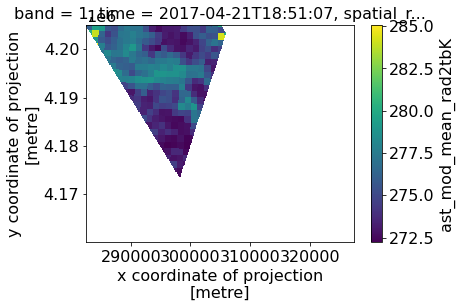

In [13]:
ds.ast_mod_mean_rad2tbK.isel(time=0).plot()

### Plot each image set separately

And compute summary stats.

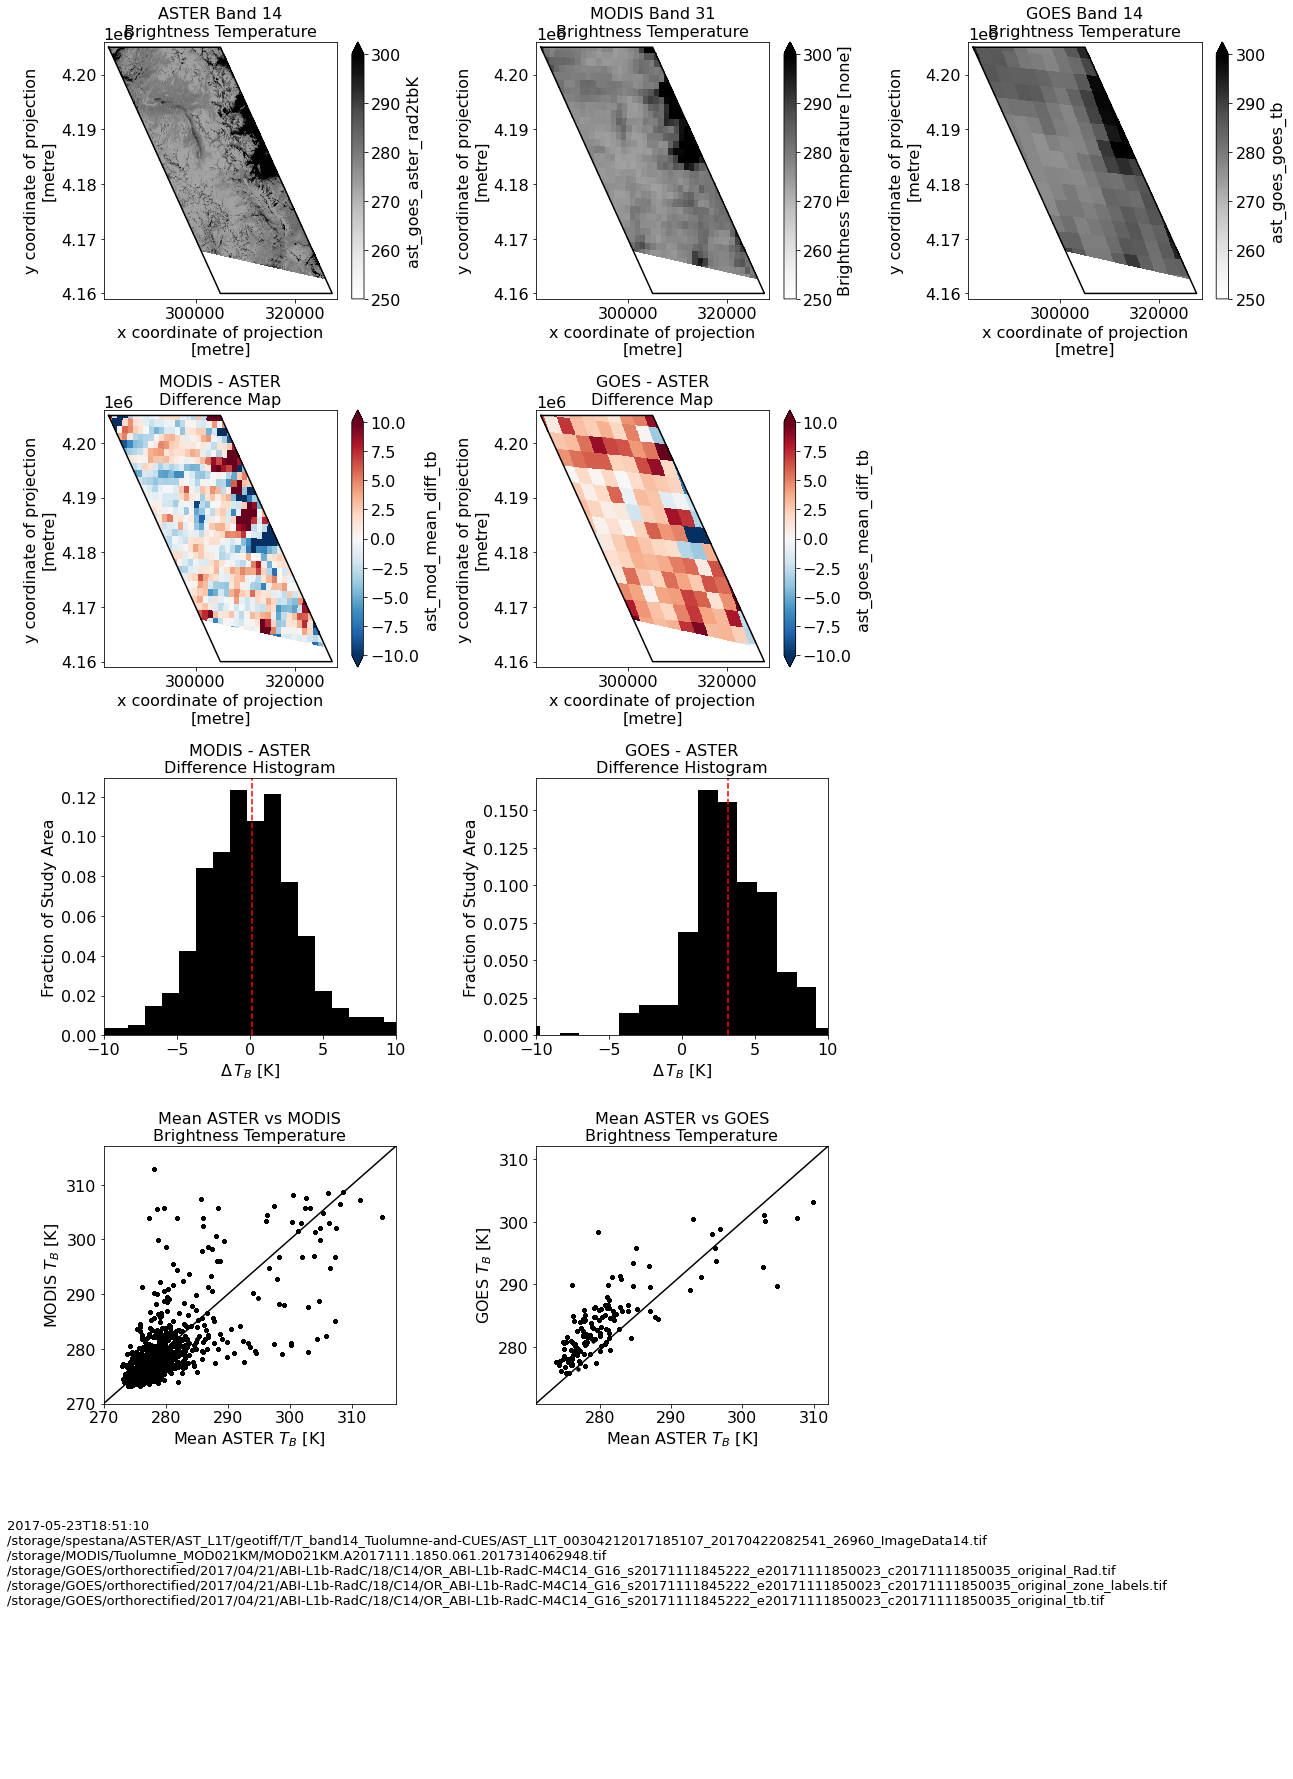

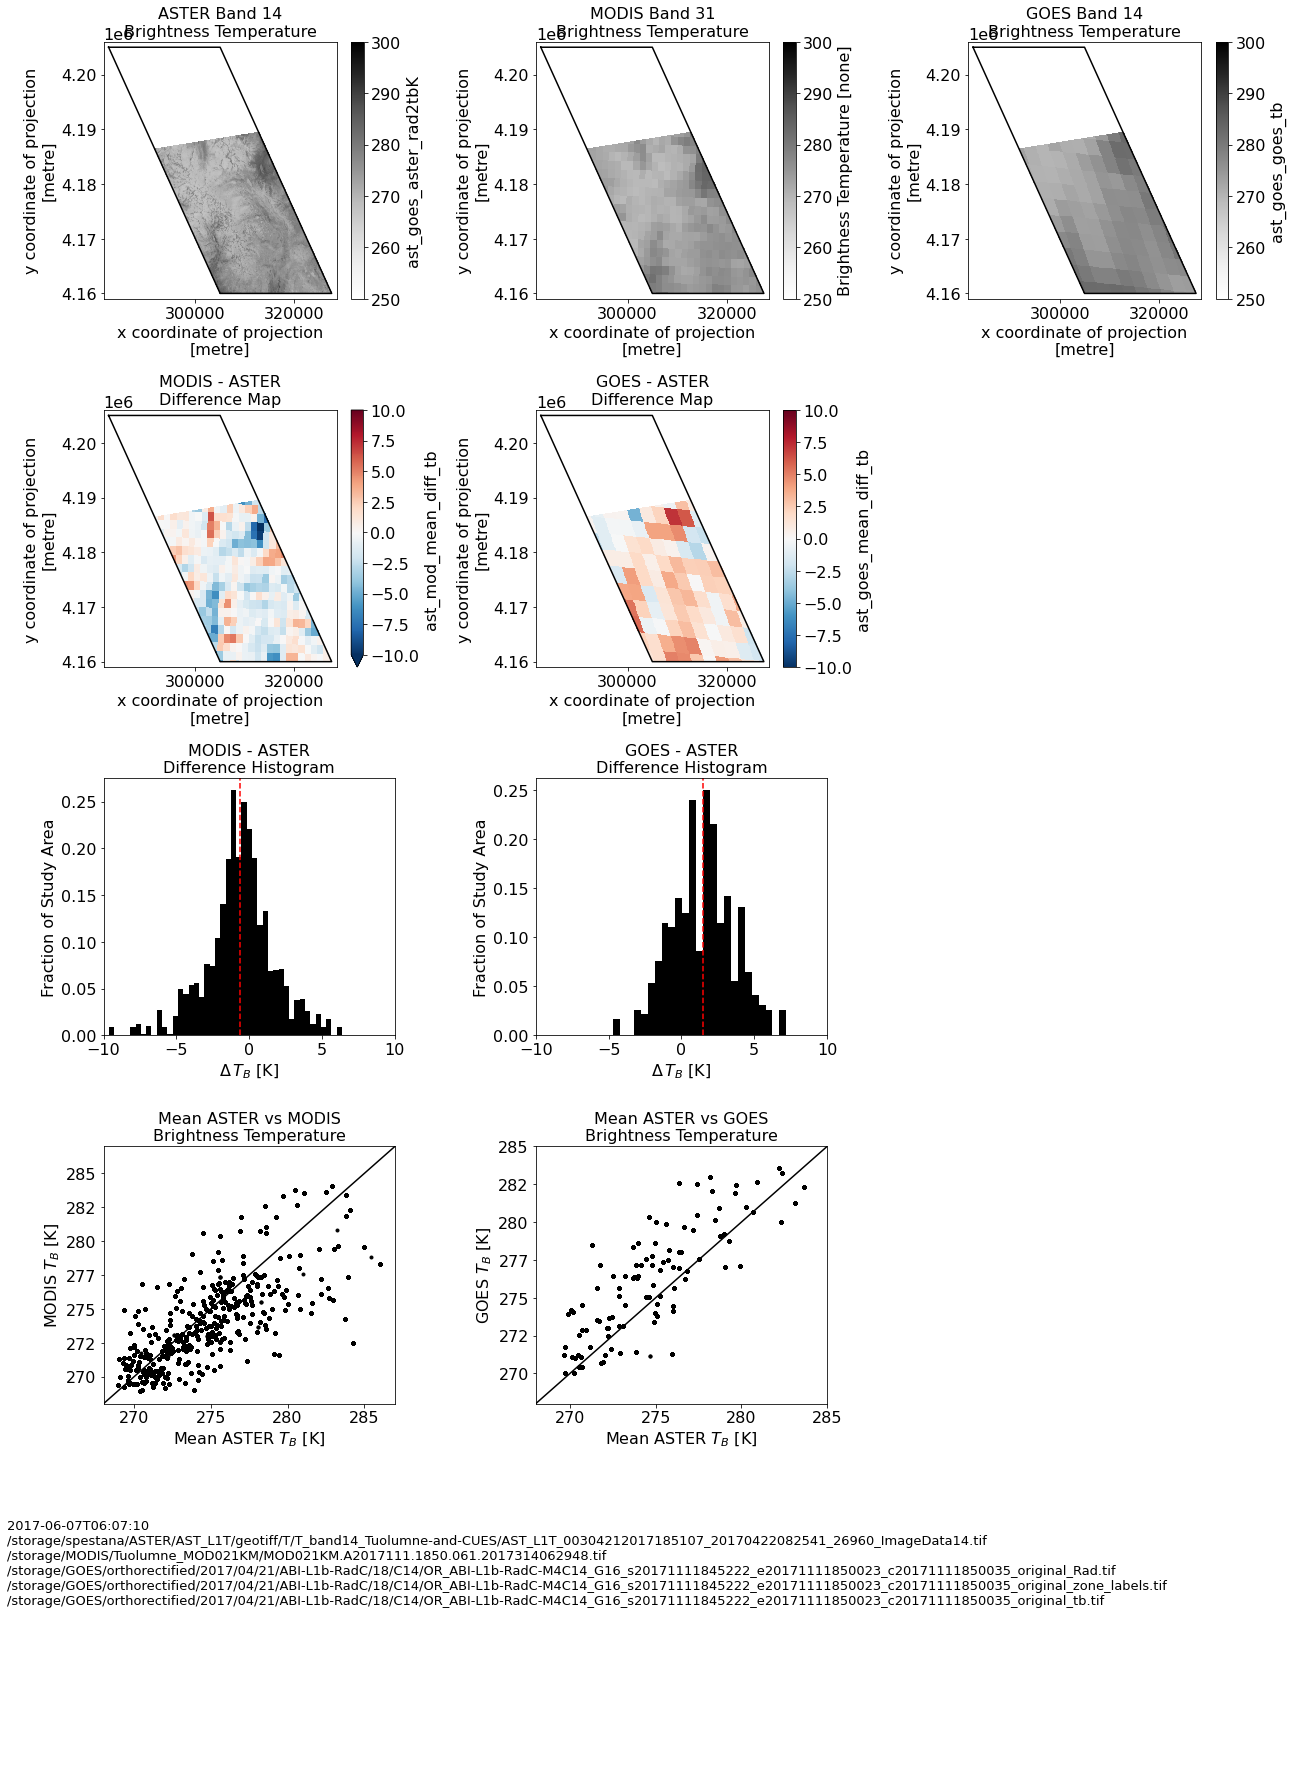

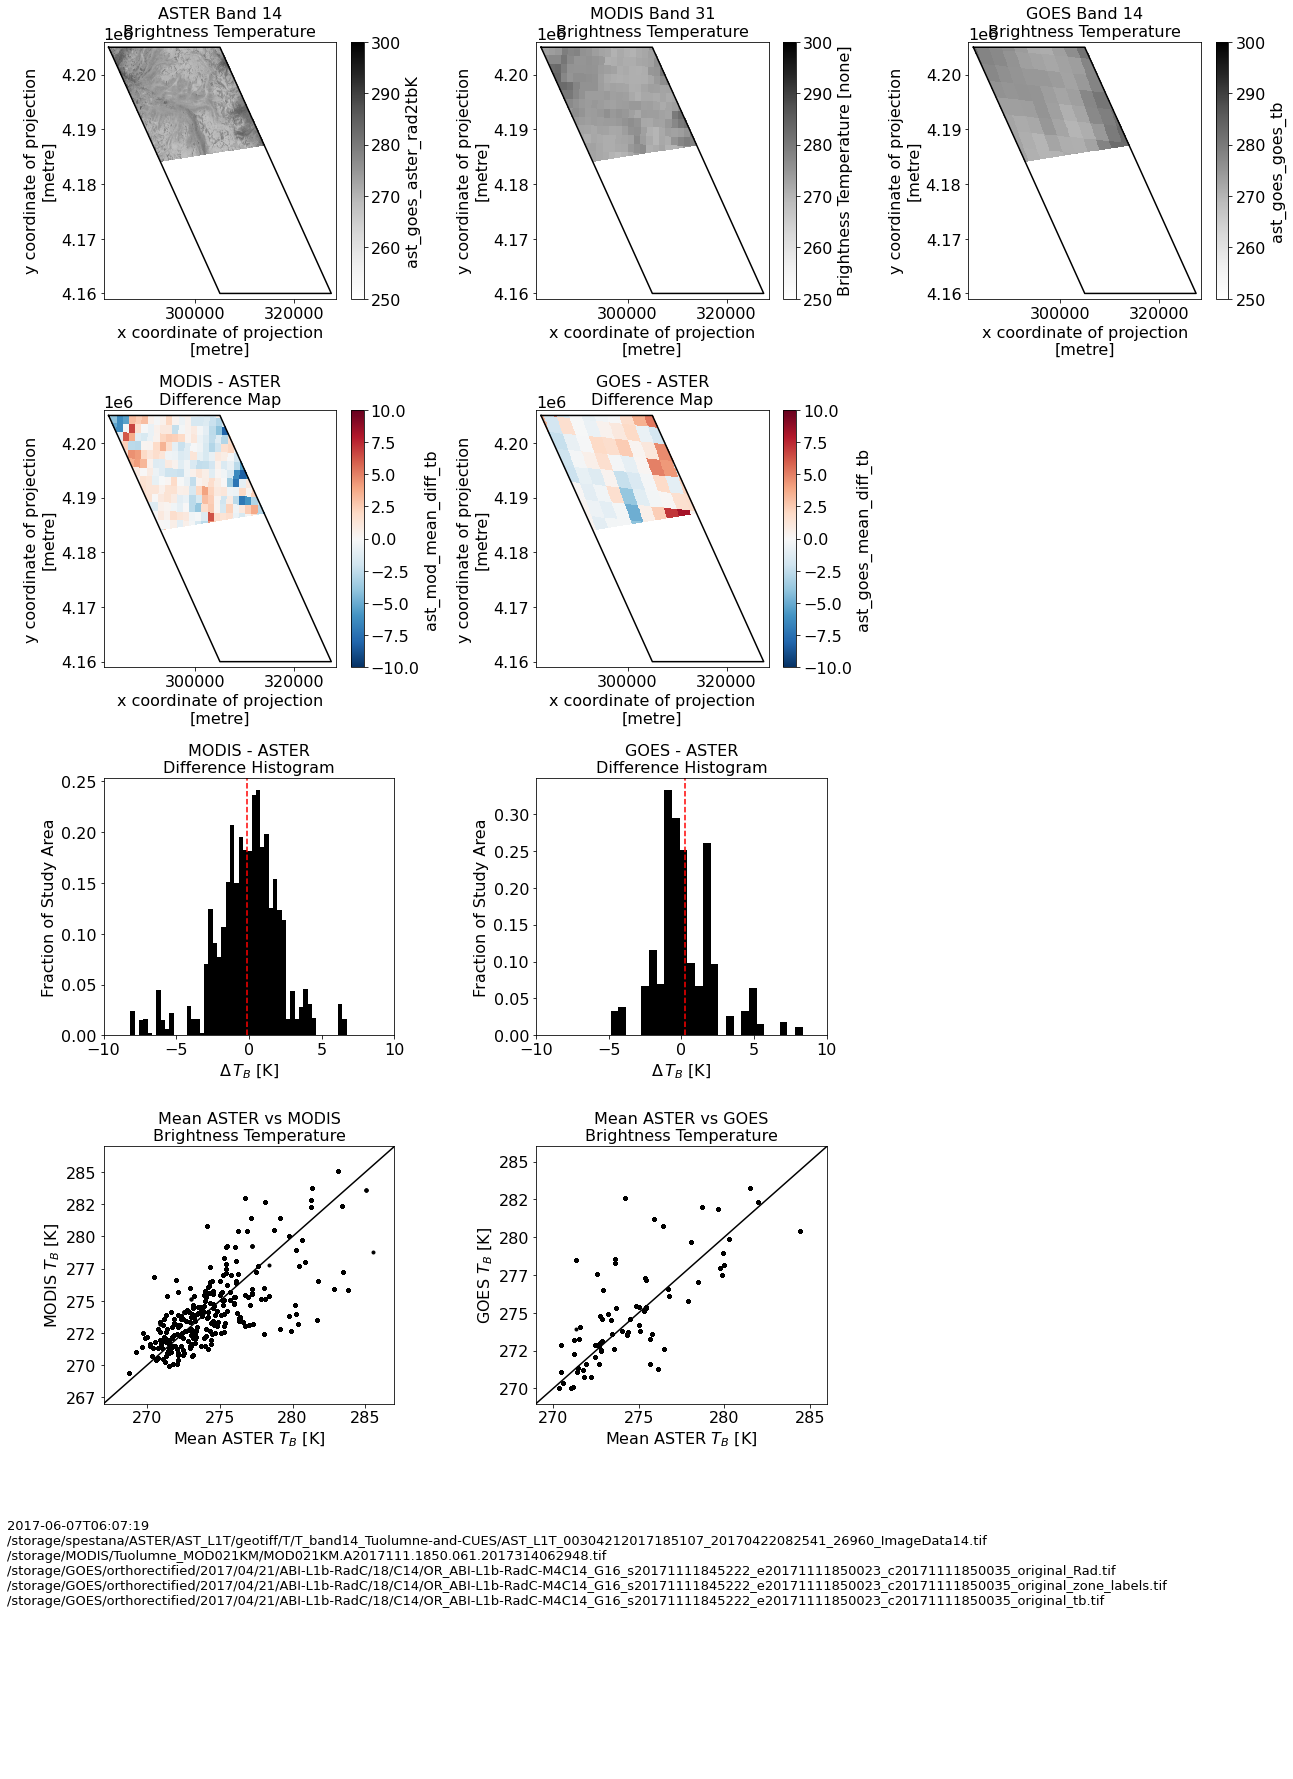

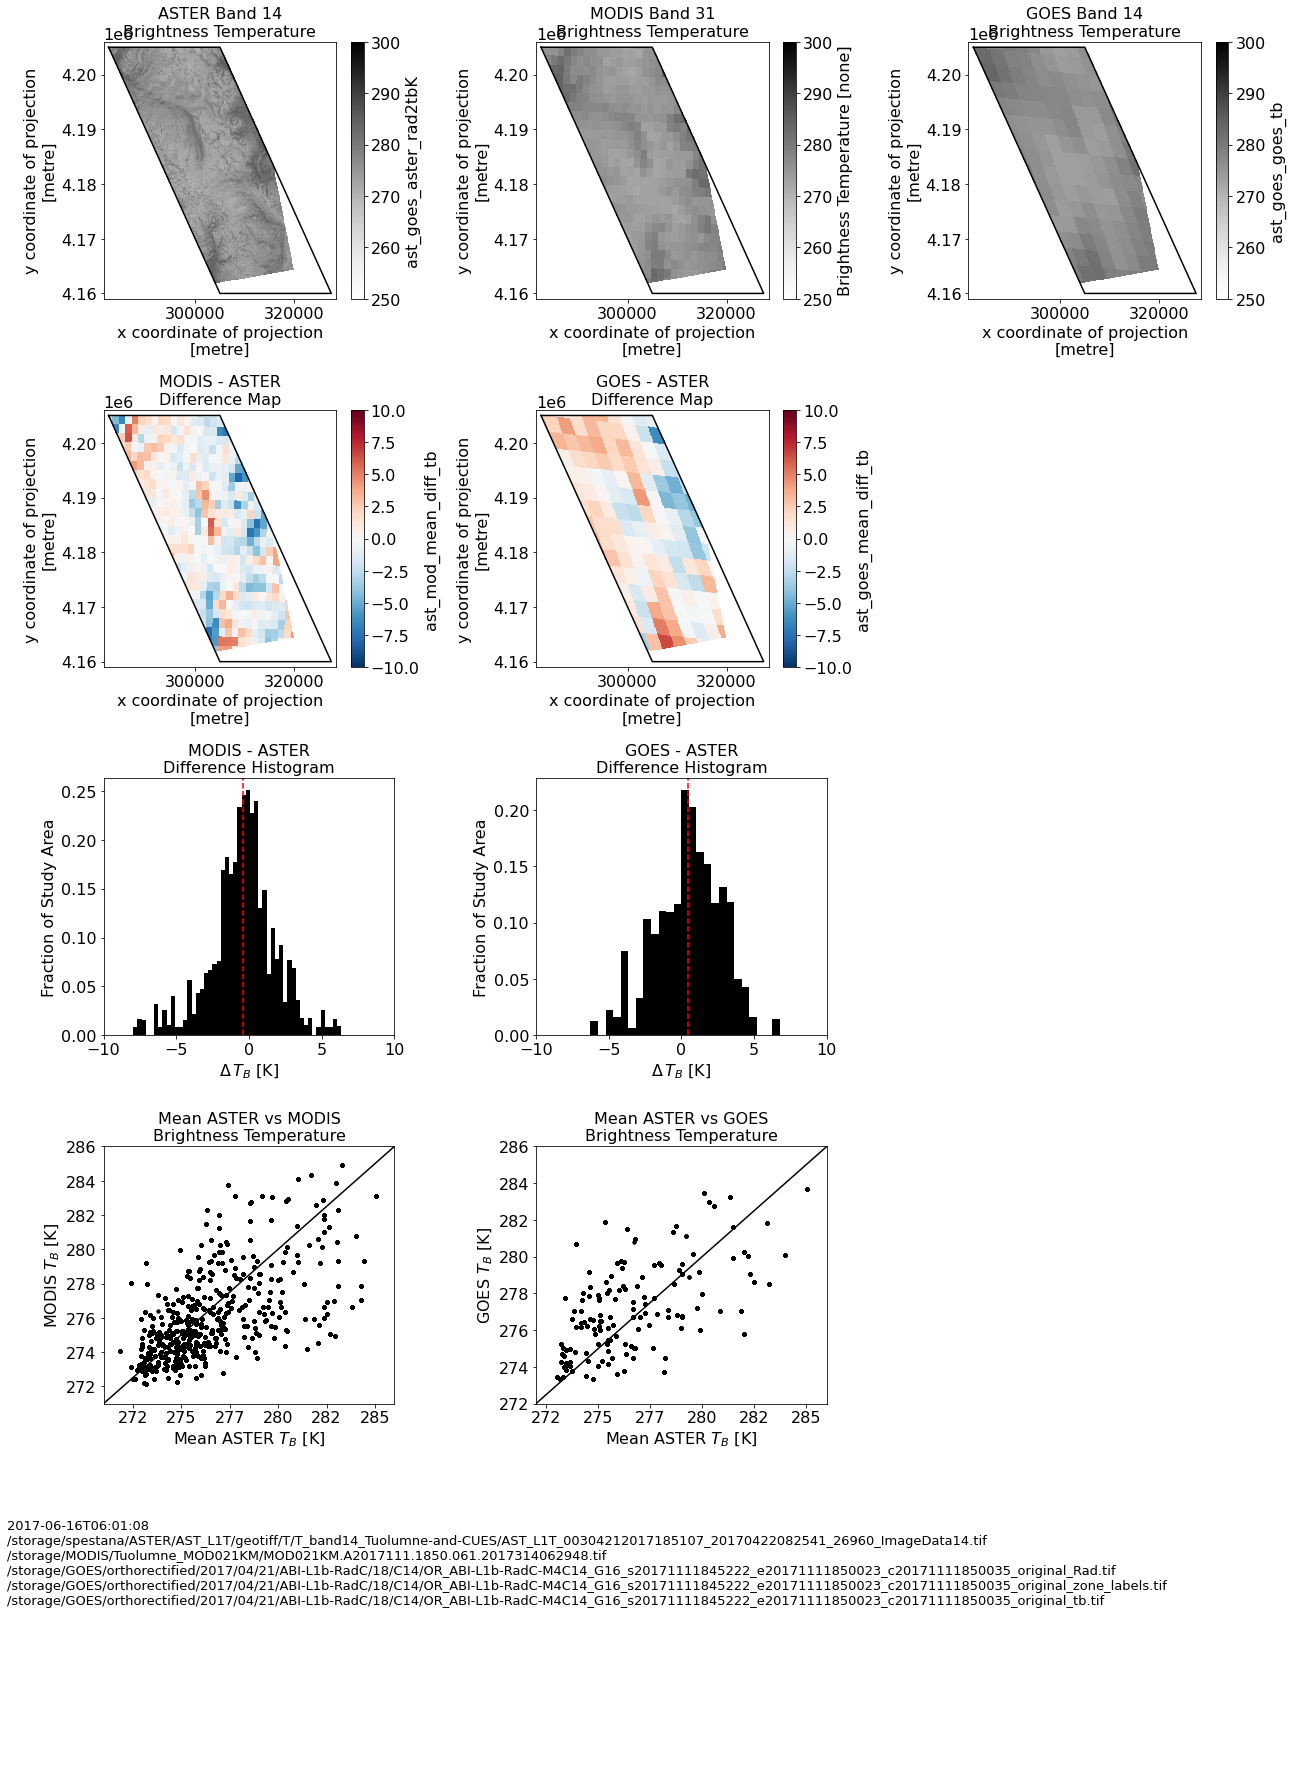

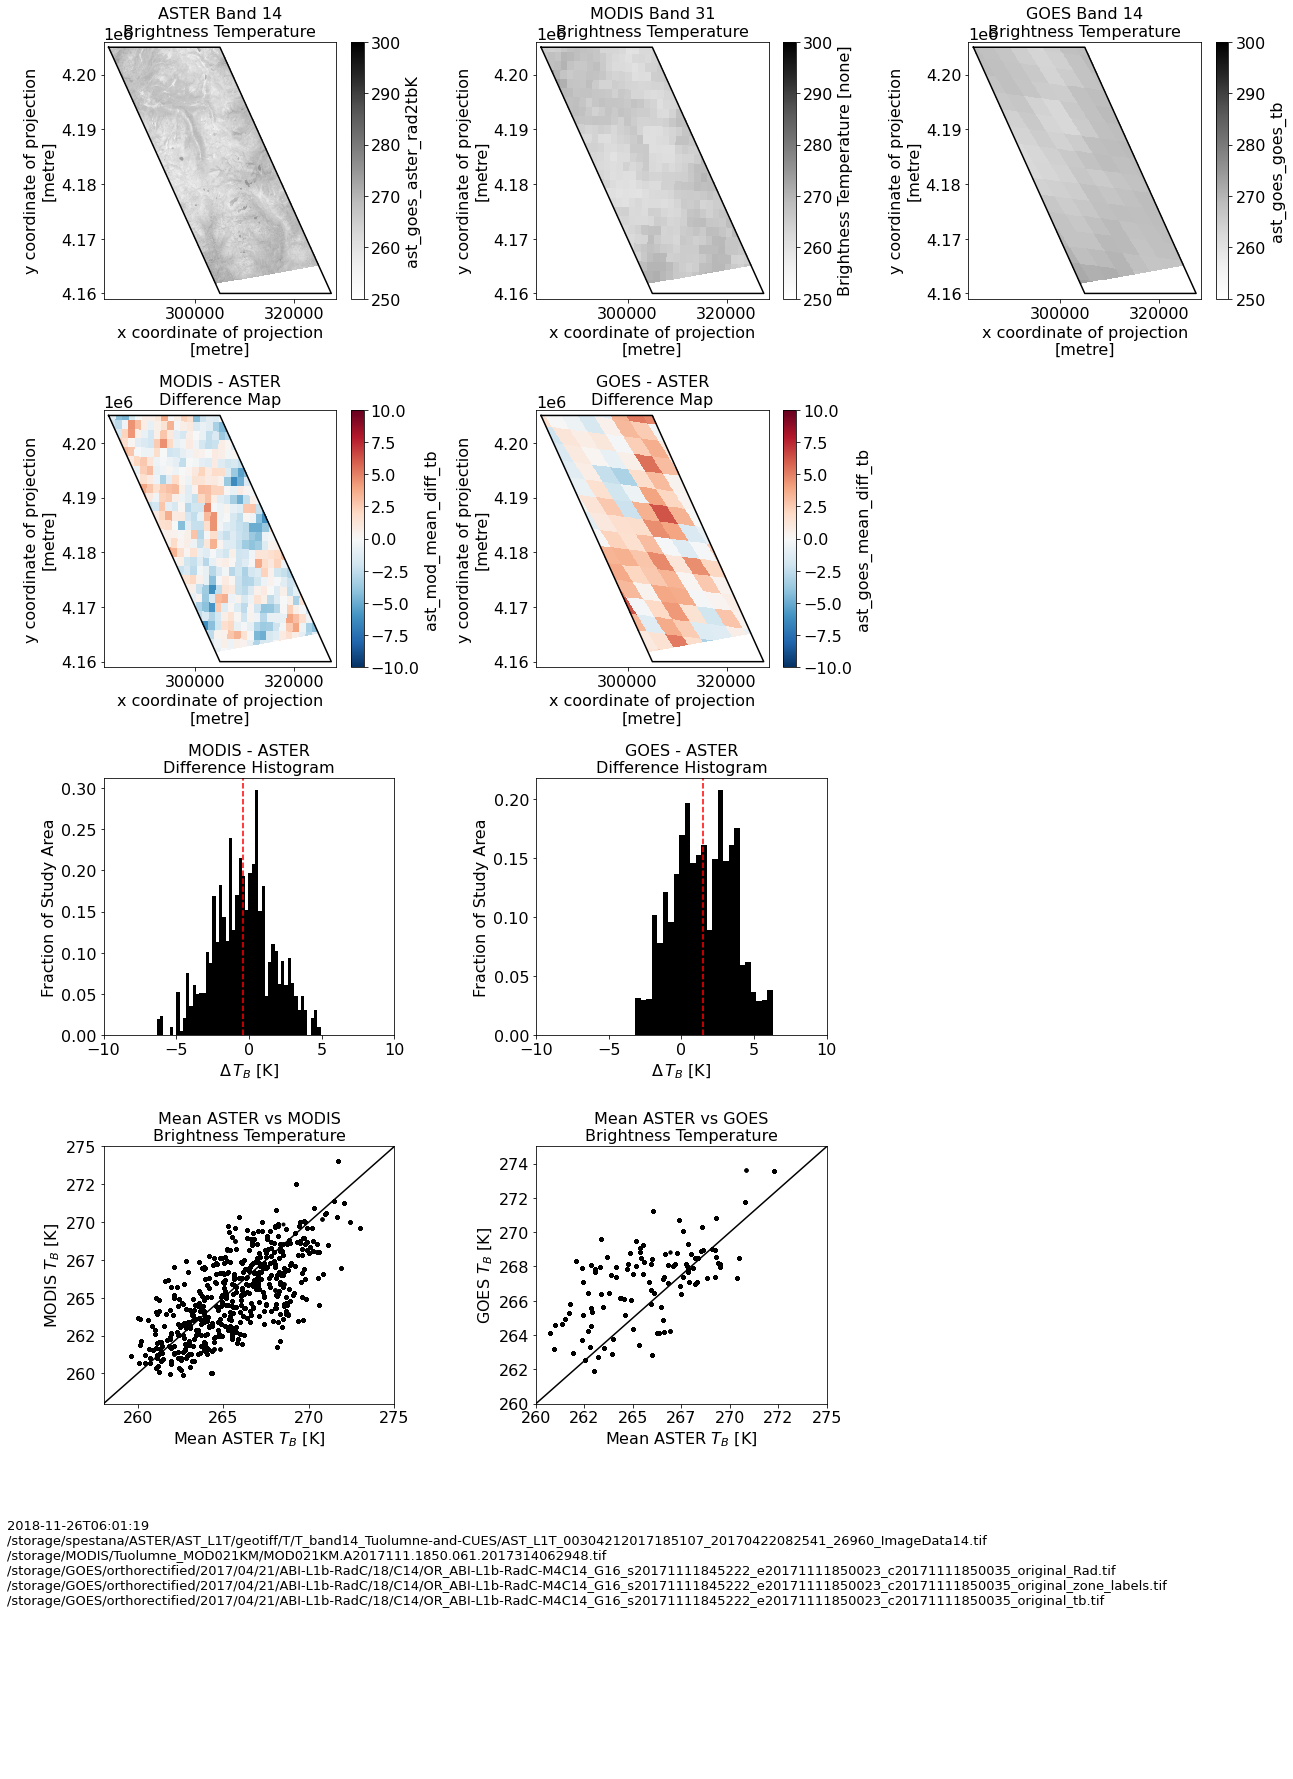

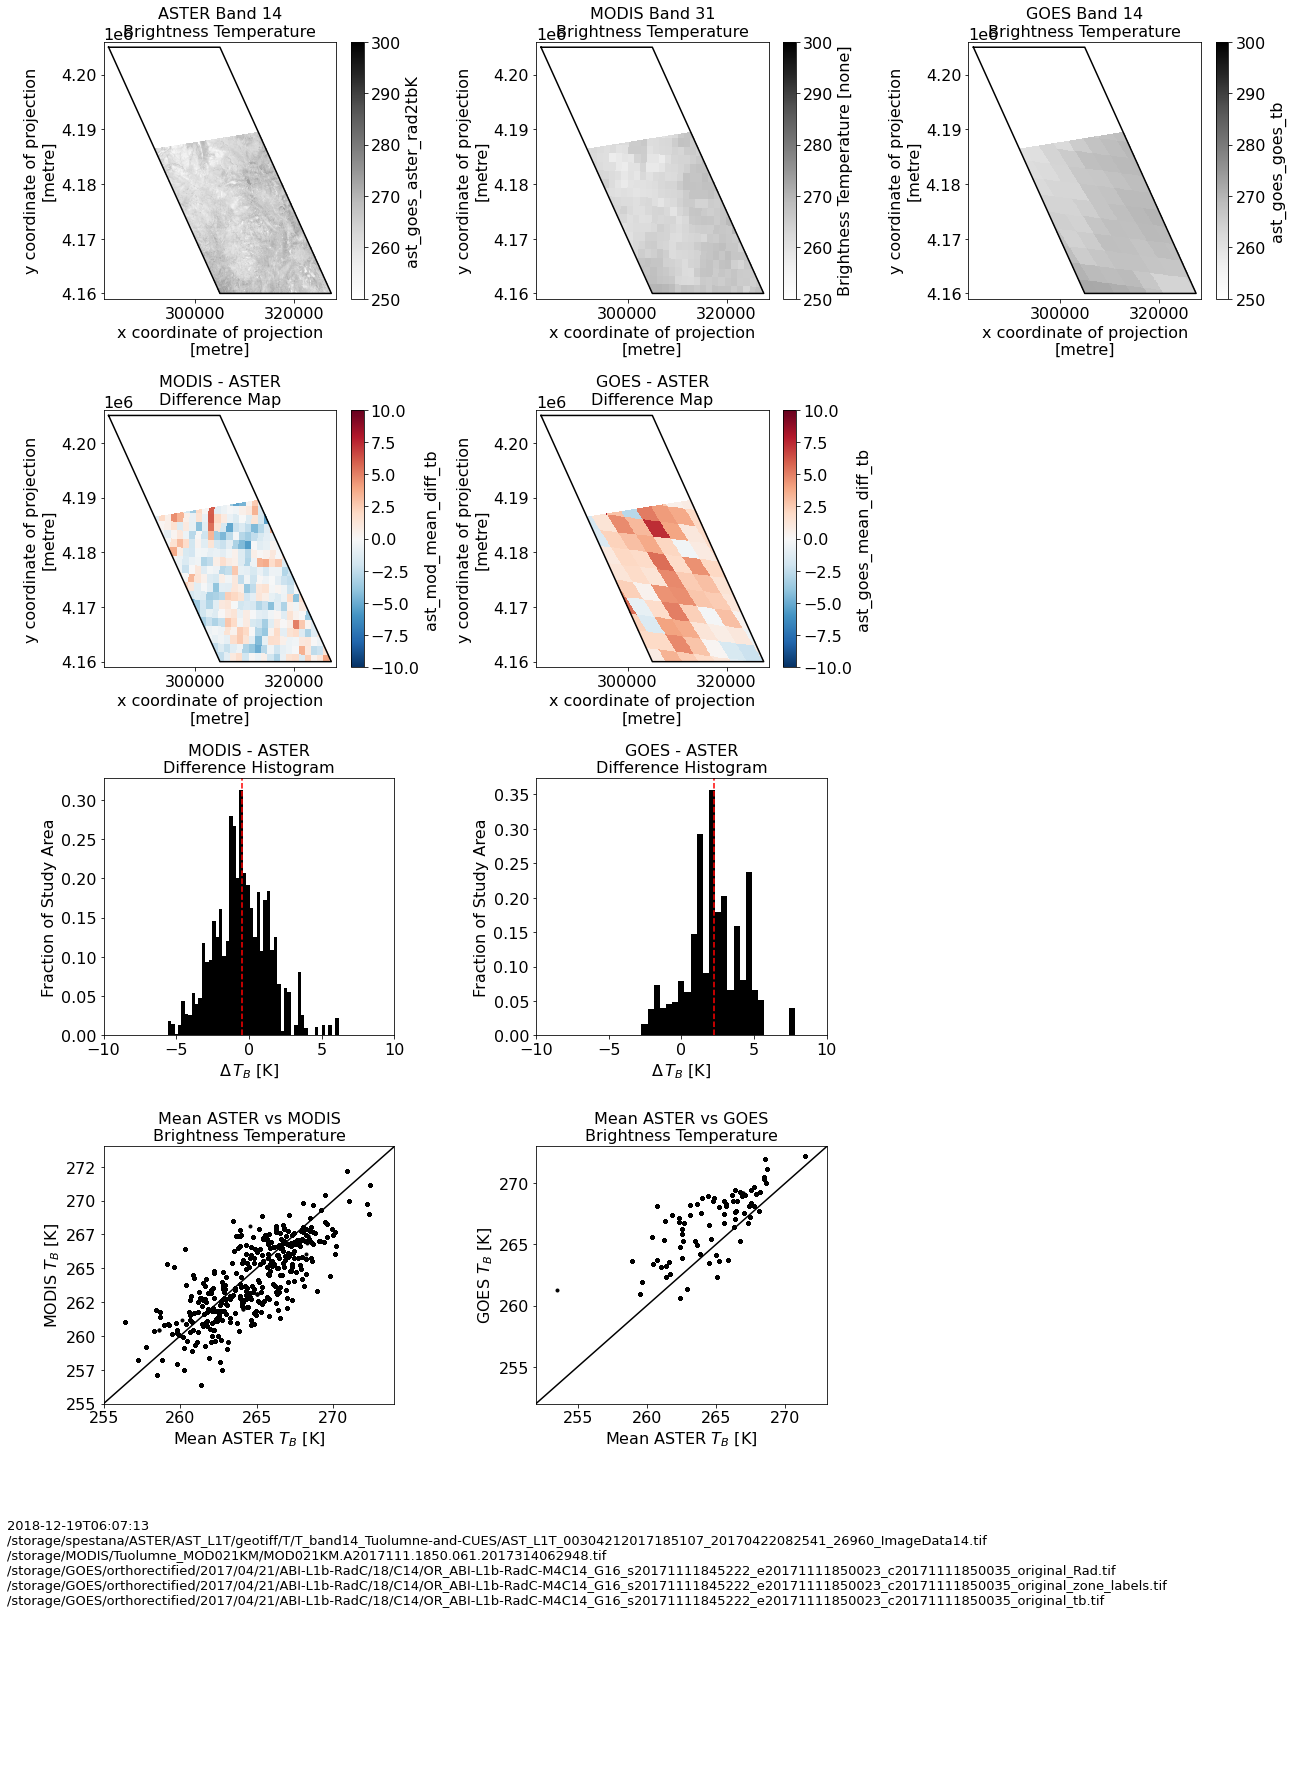

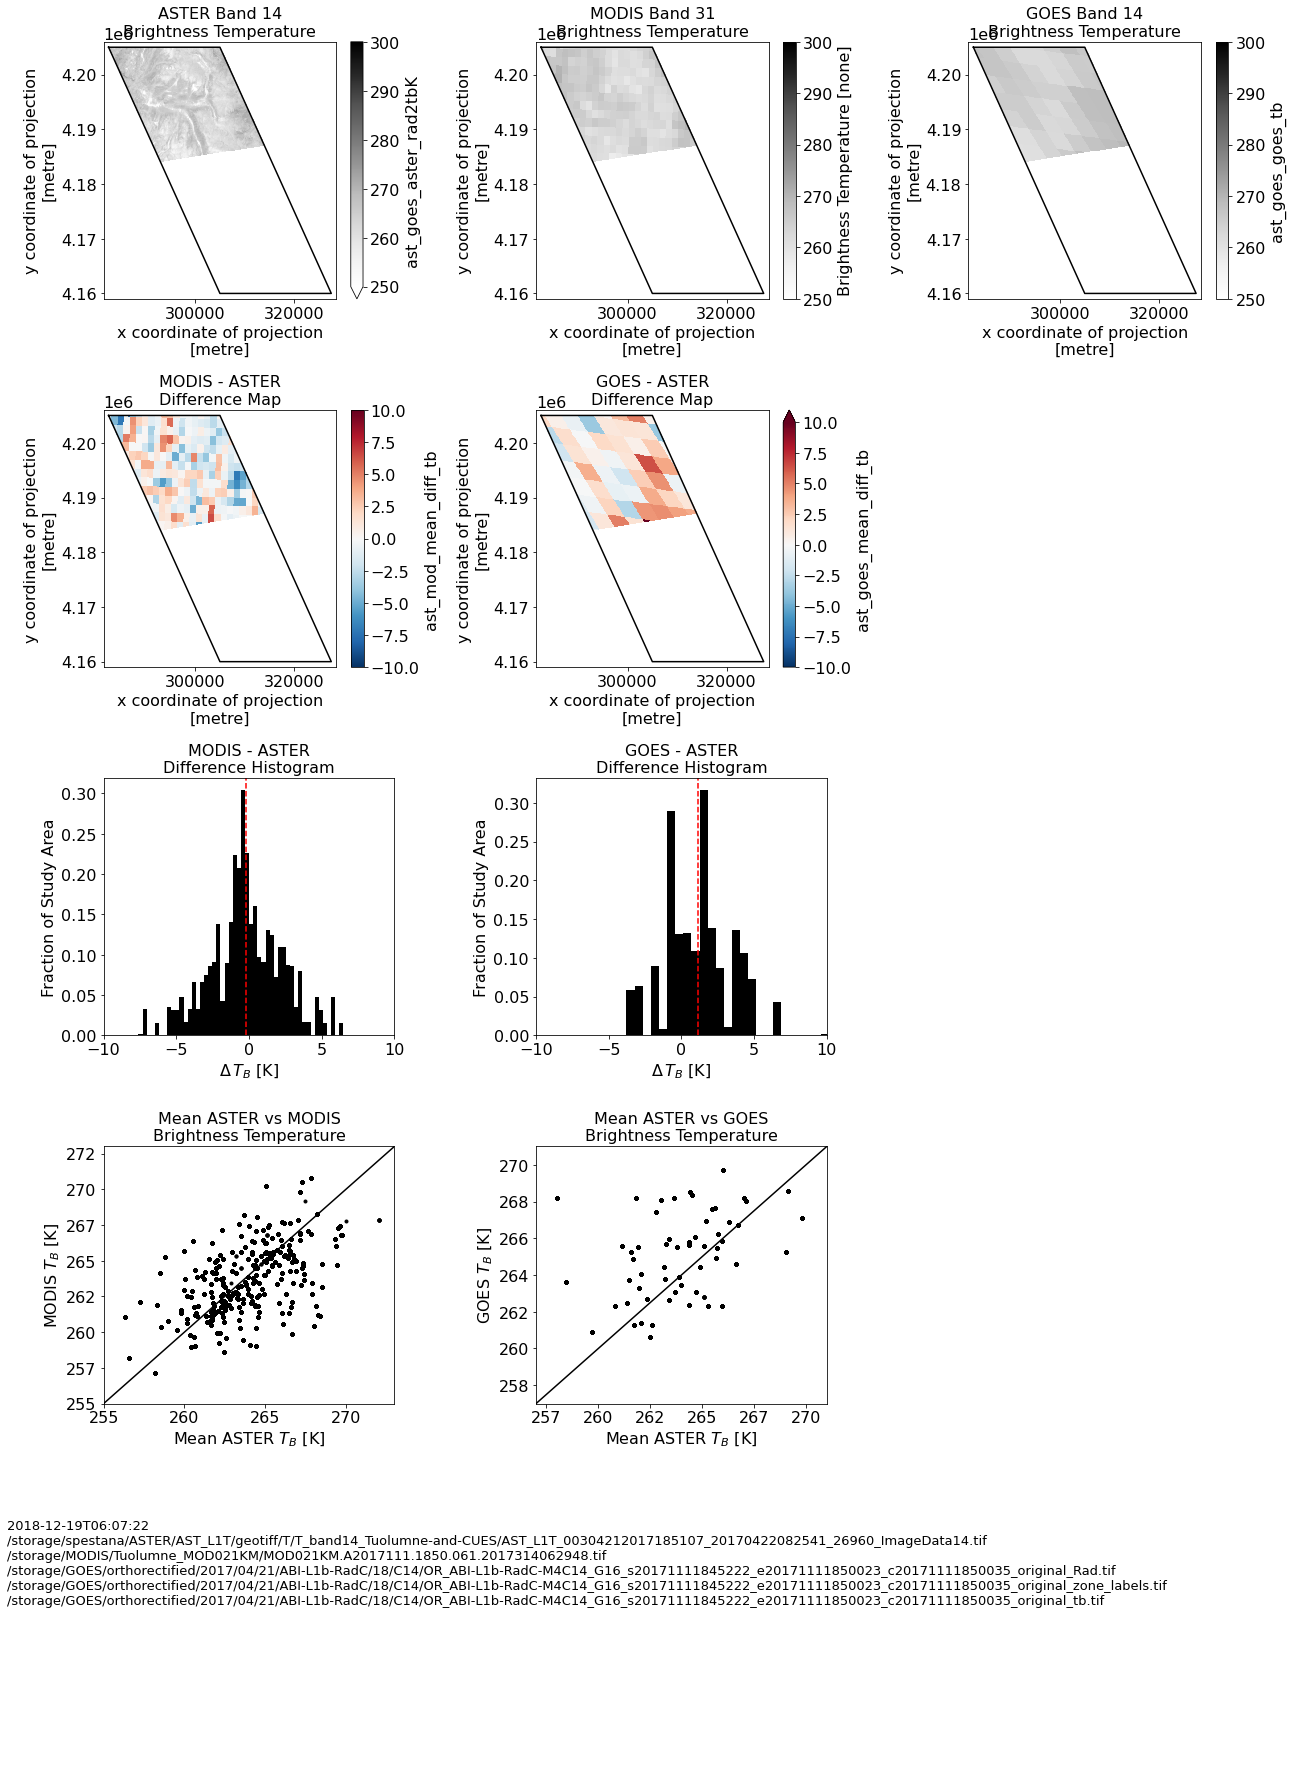

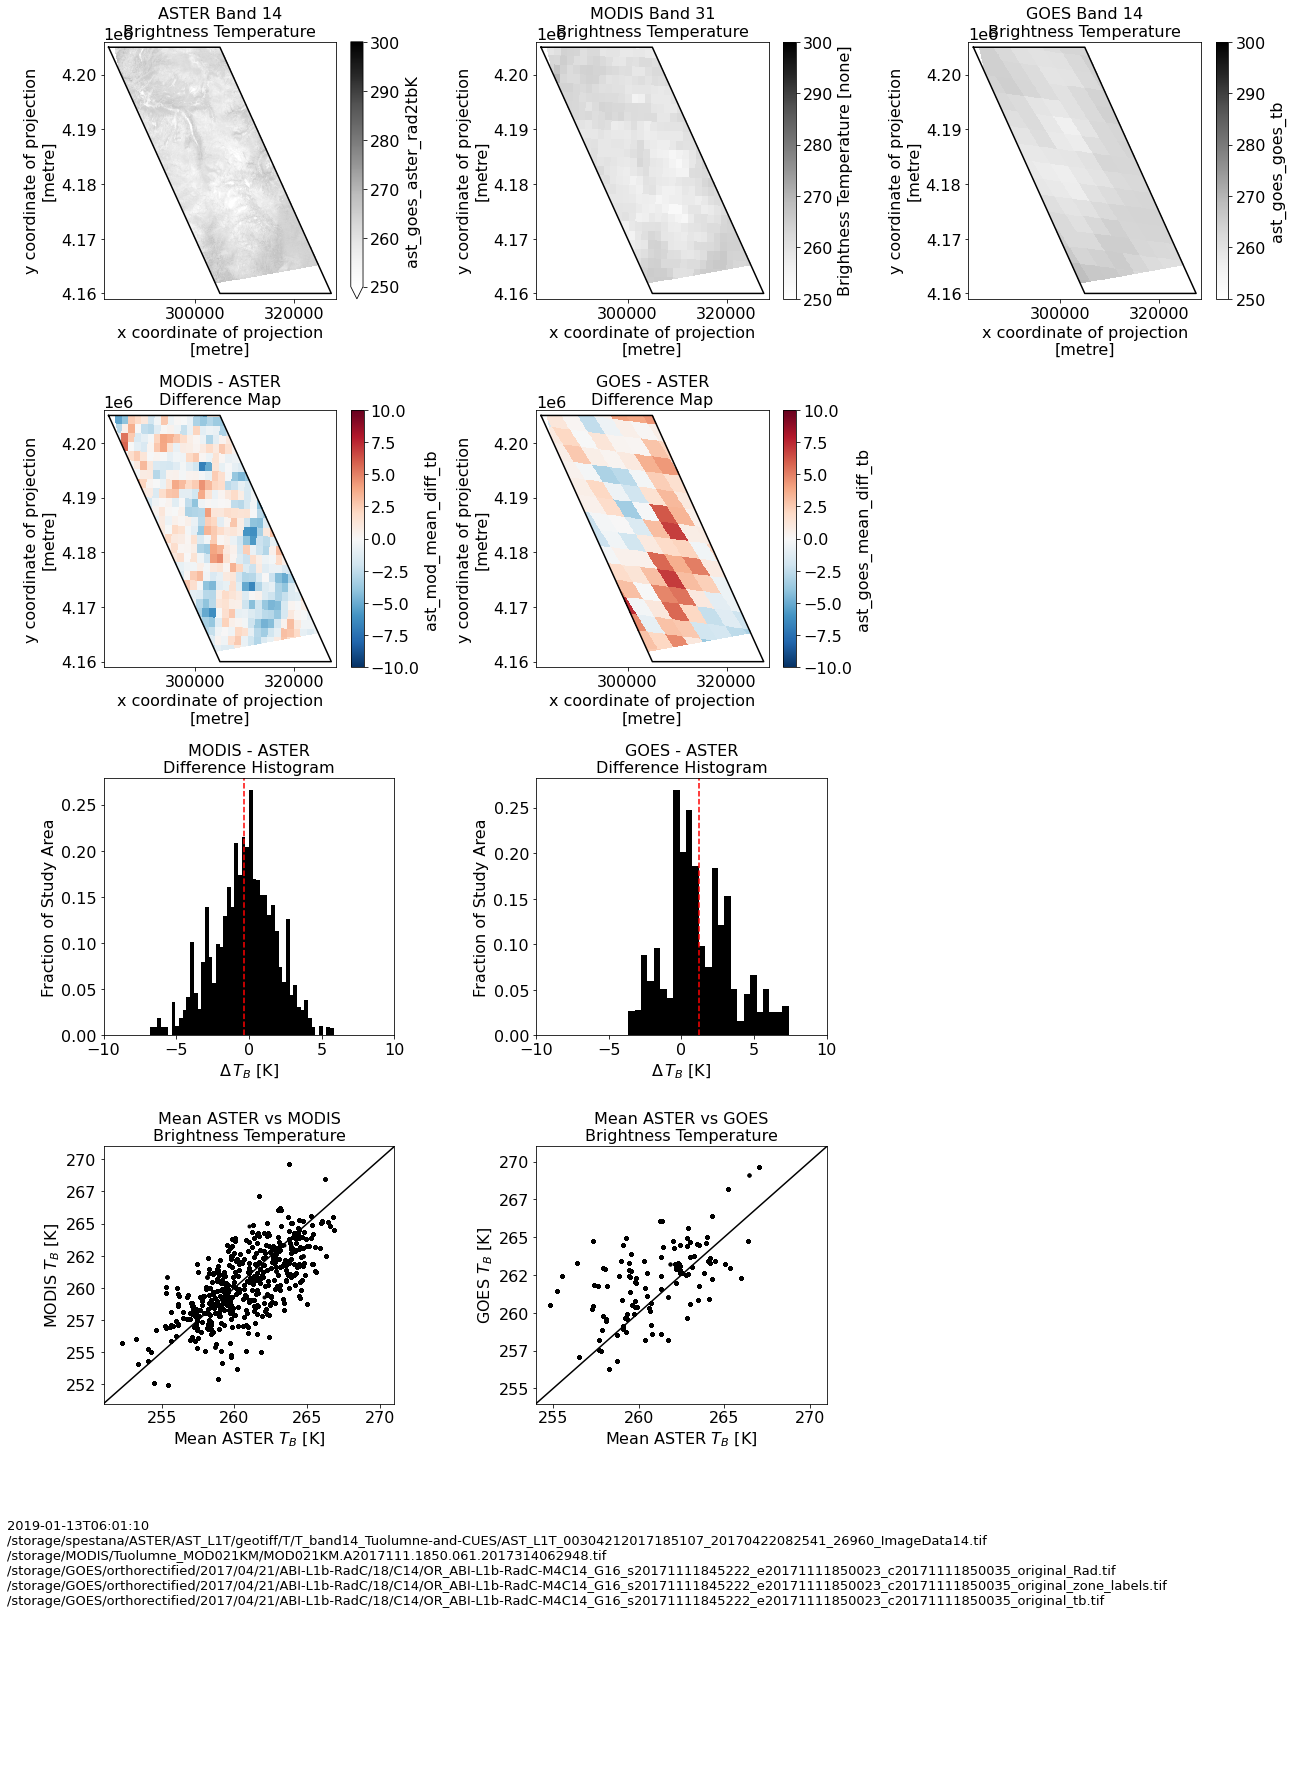

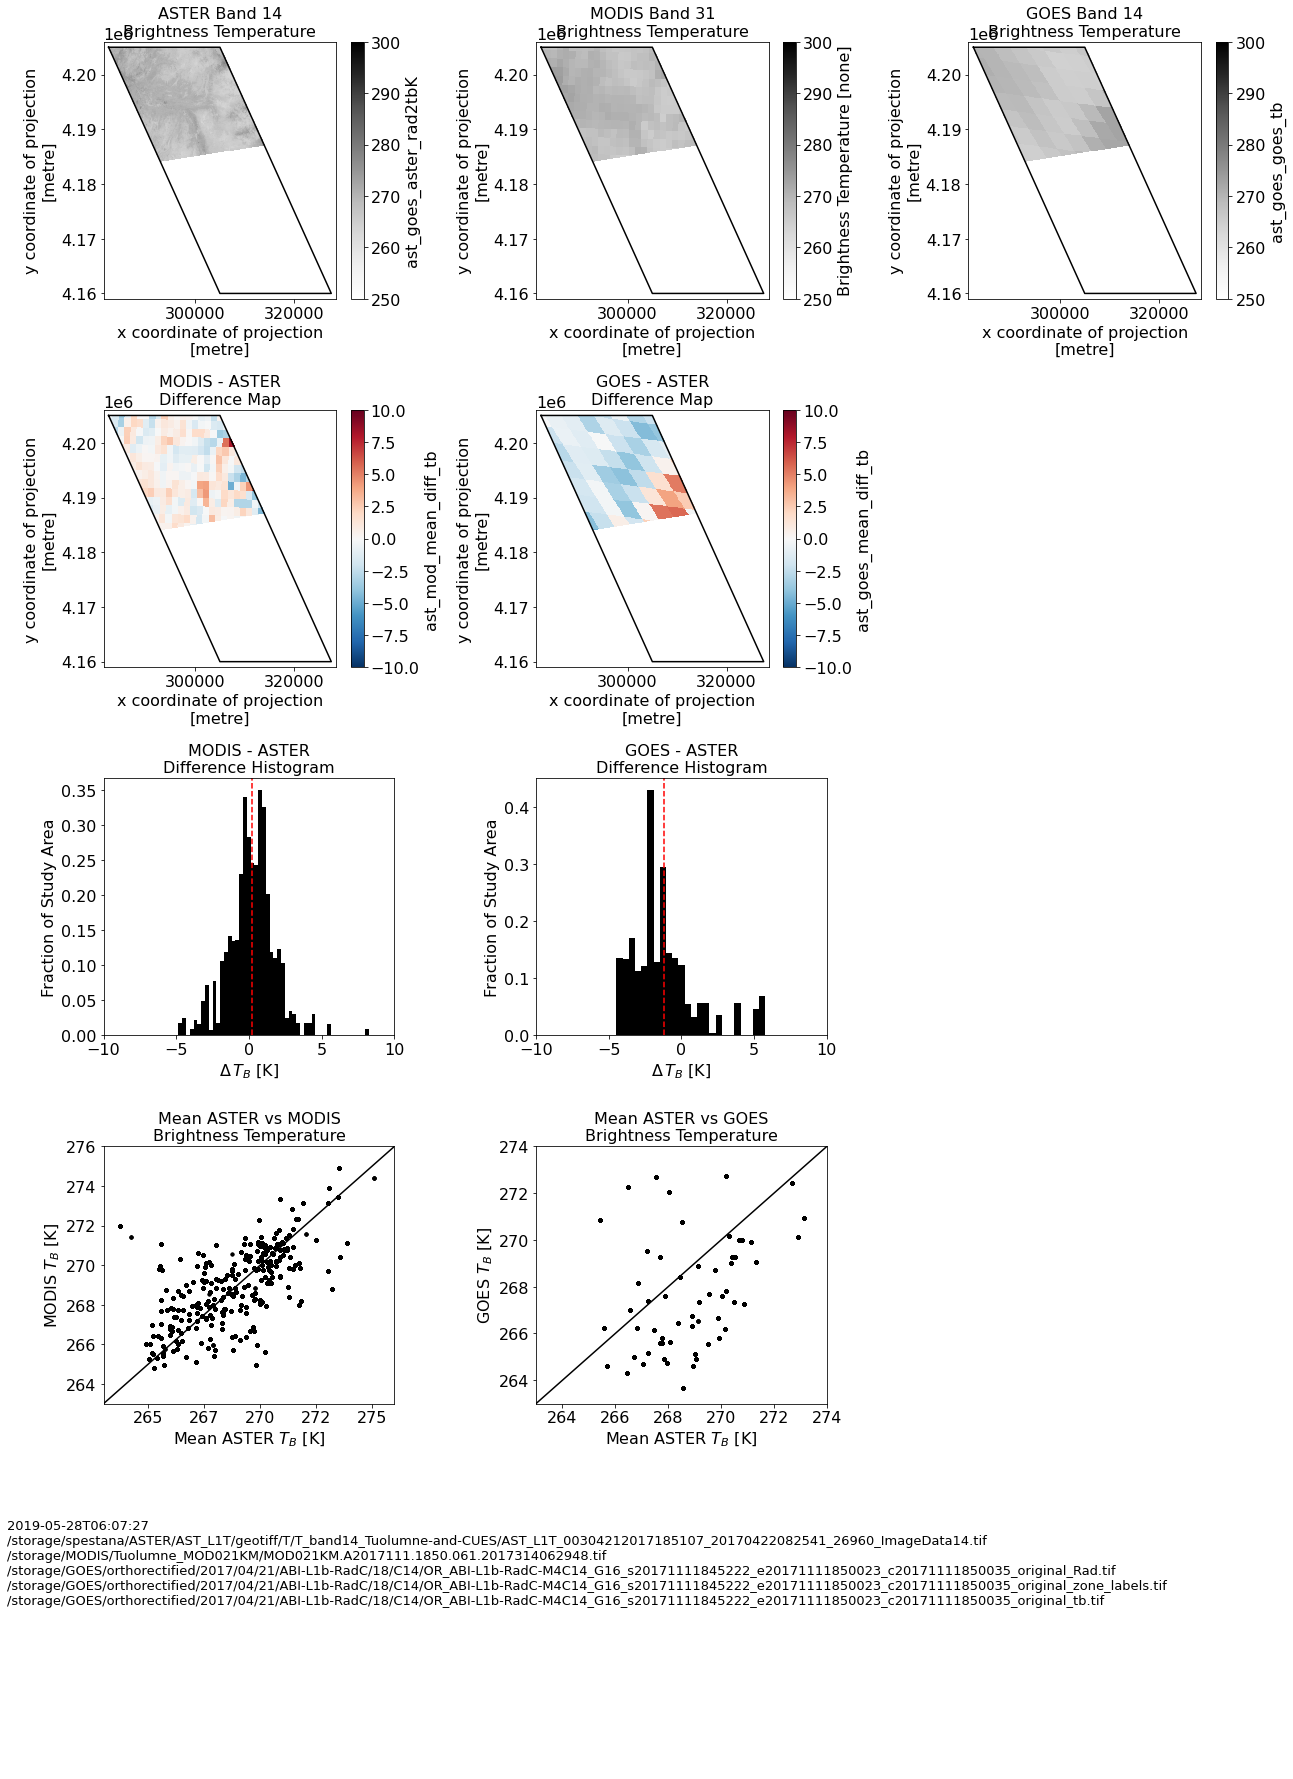

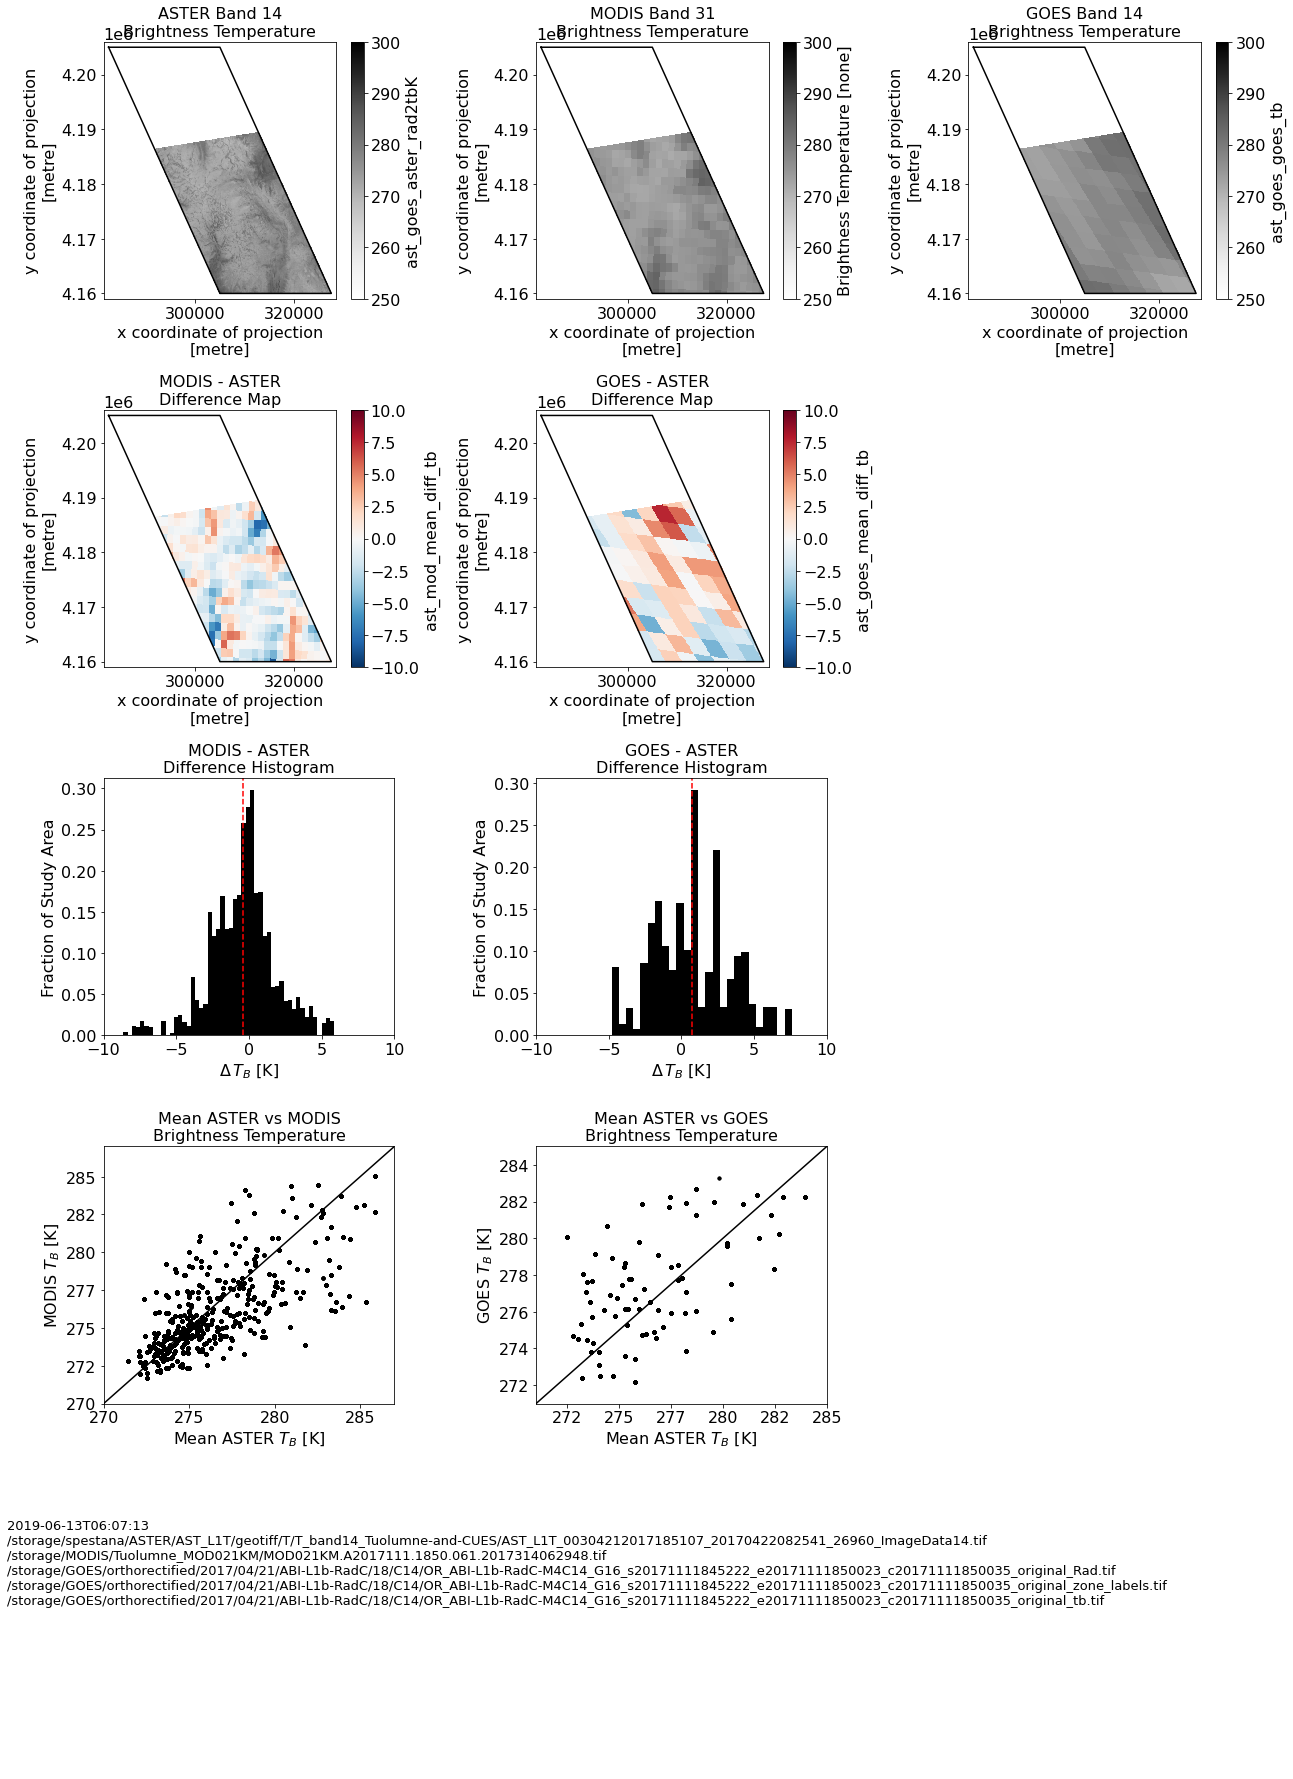

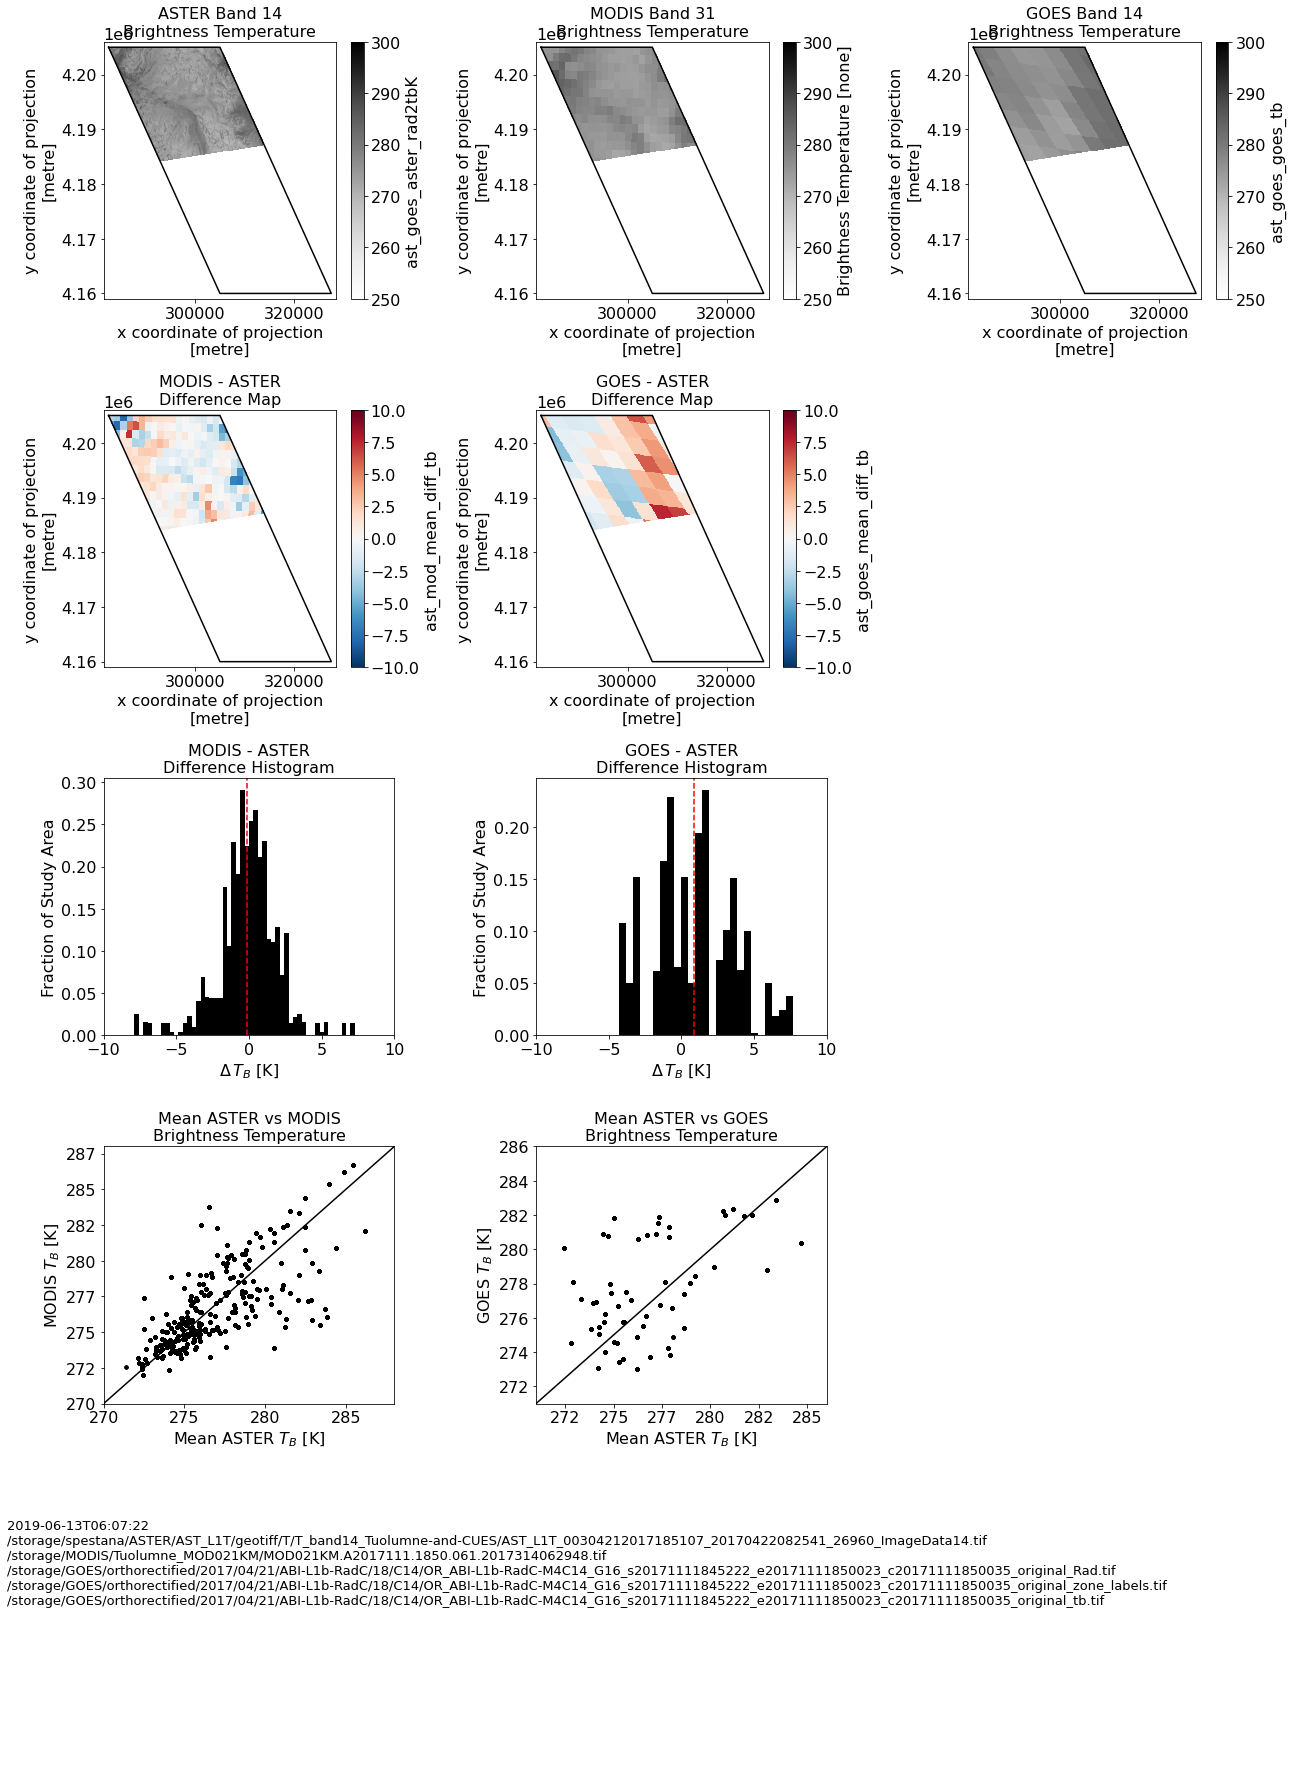

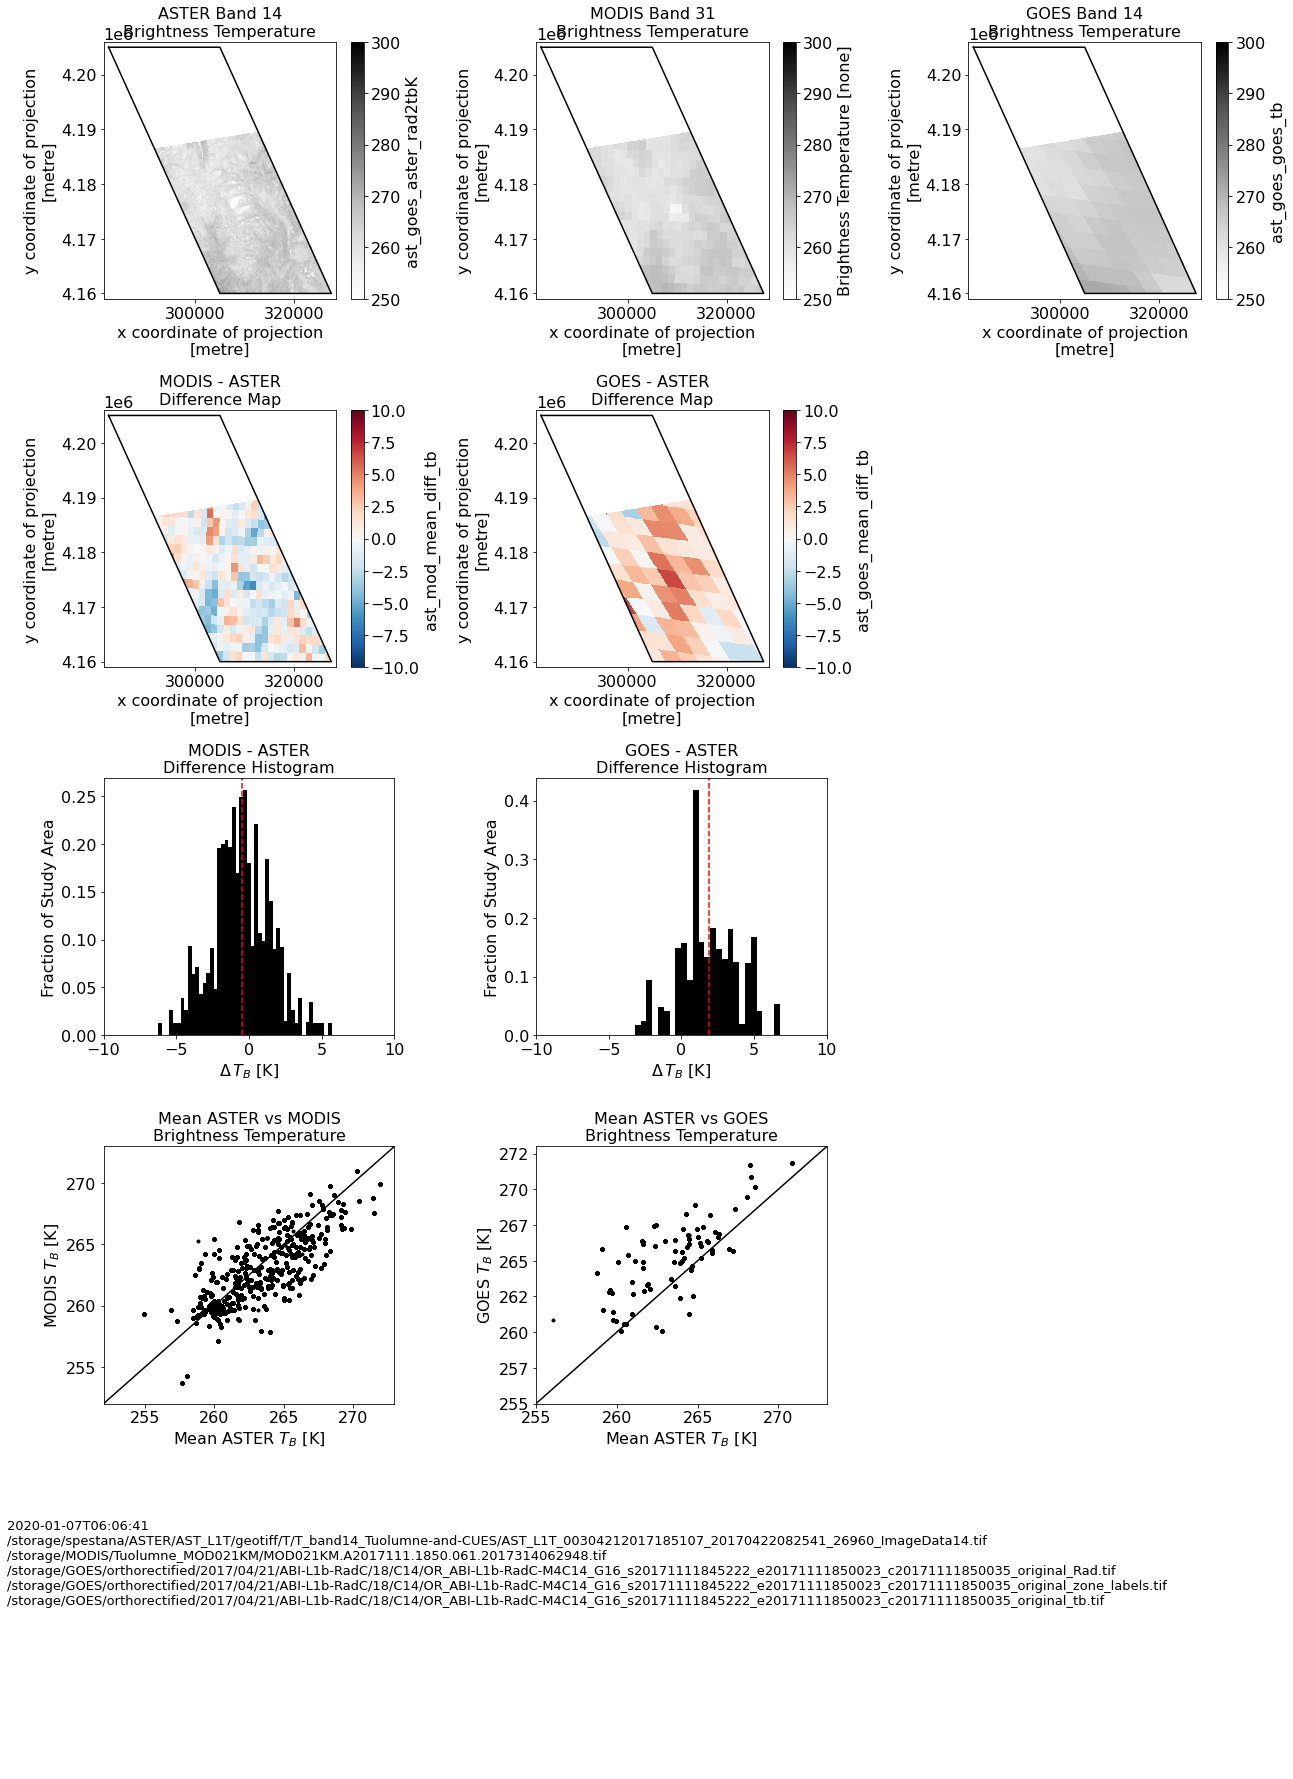

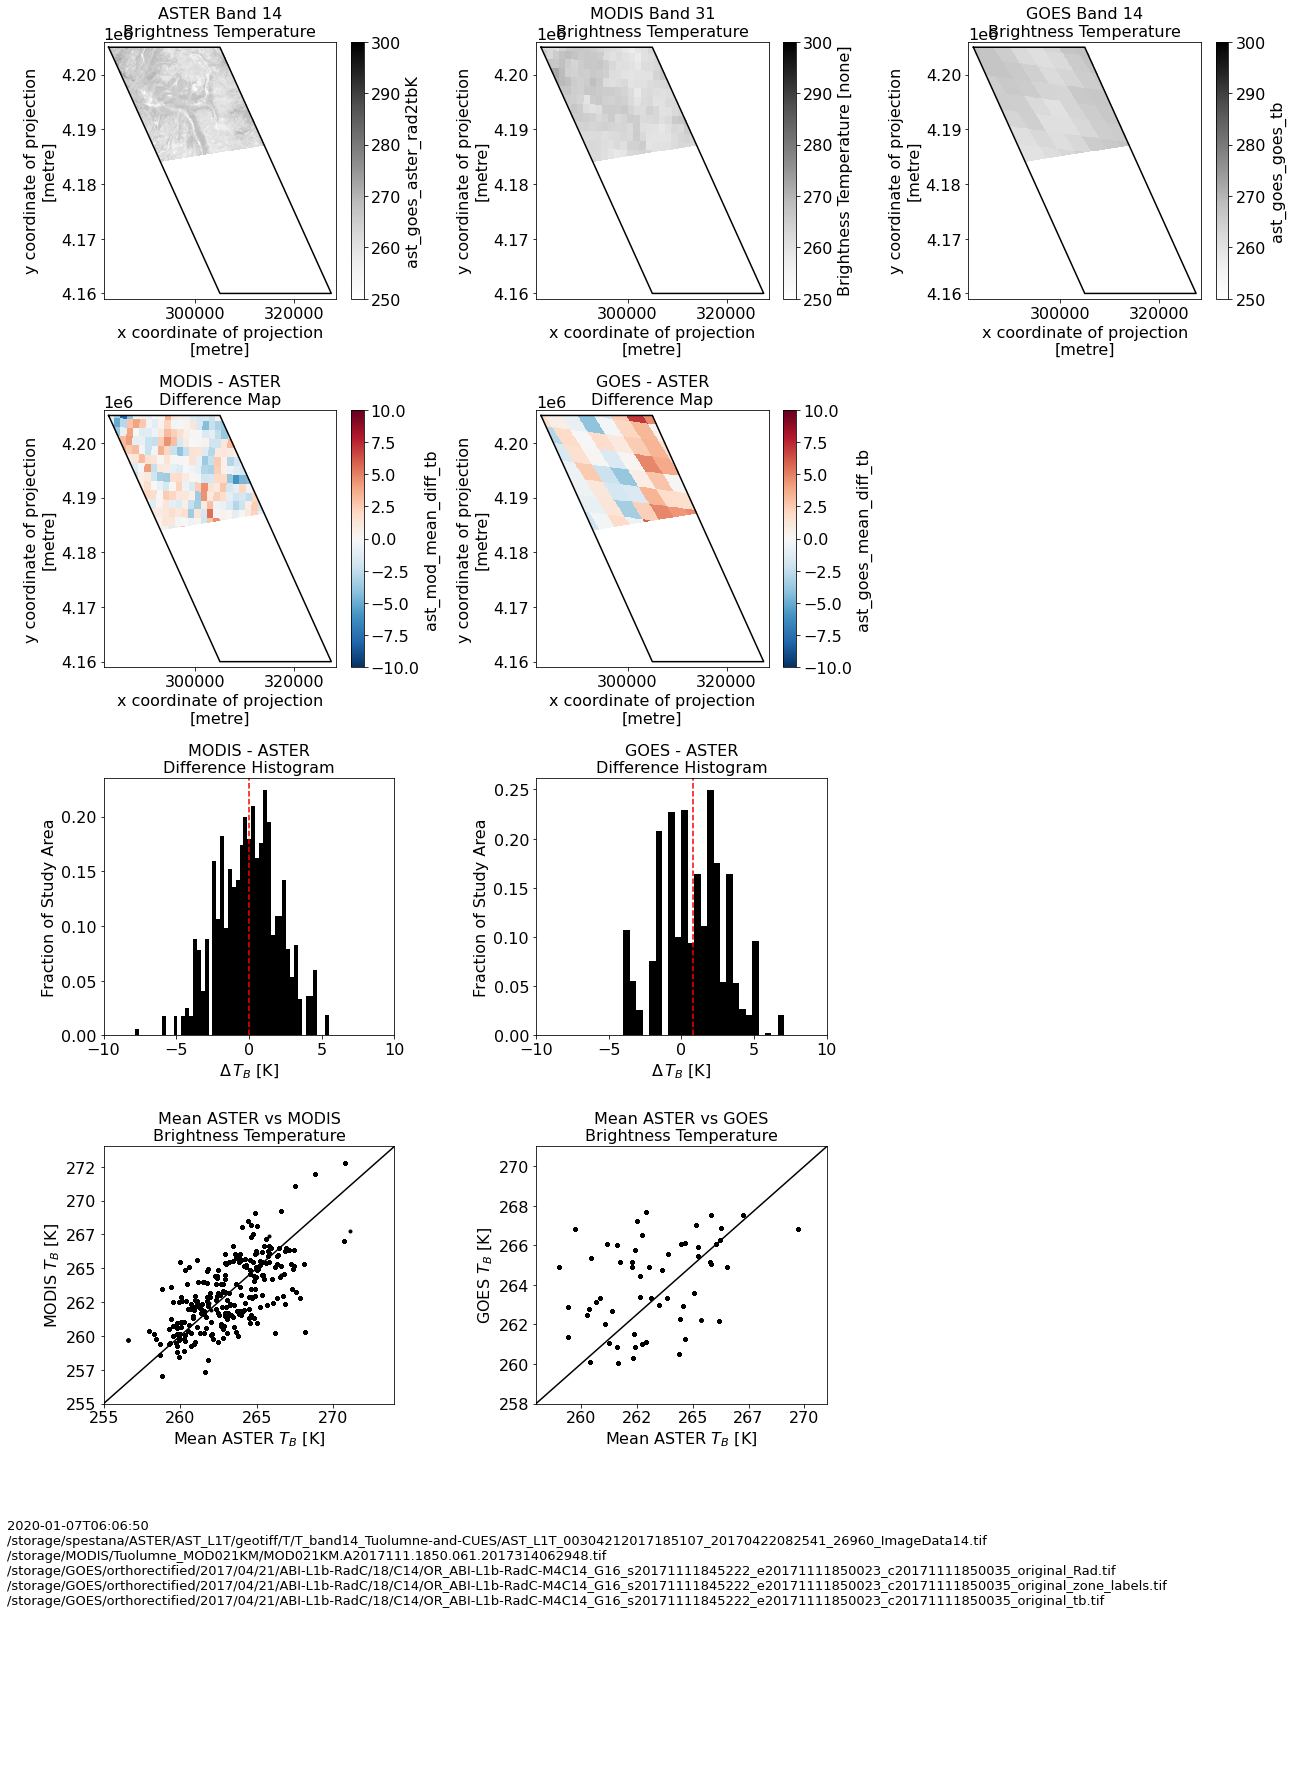

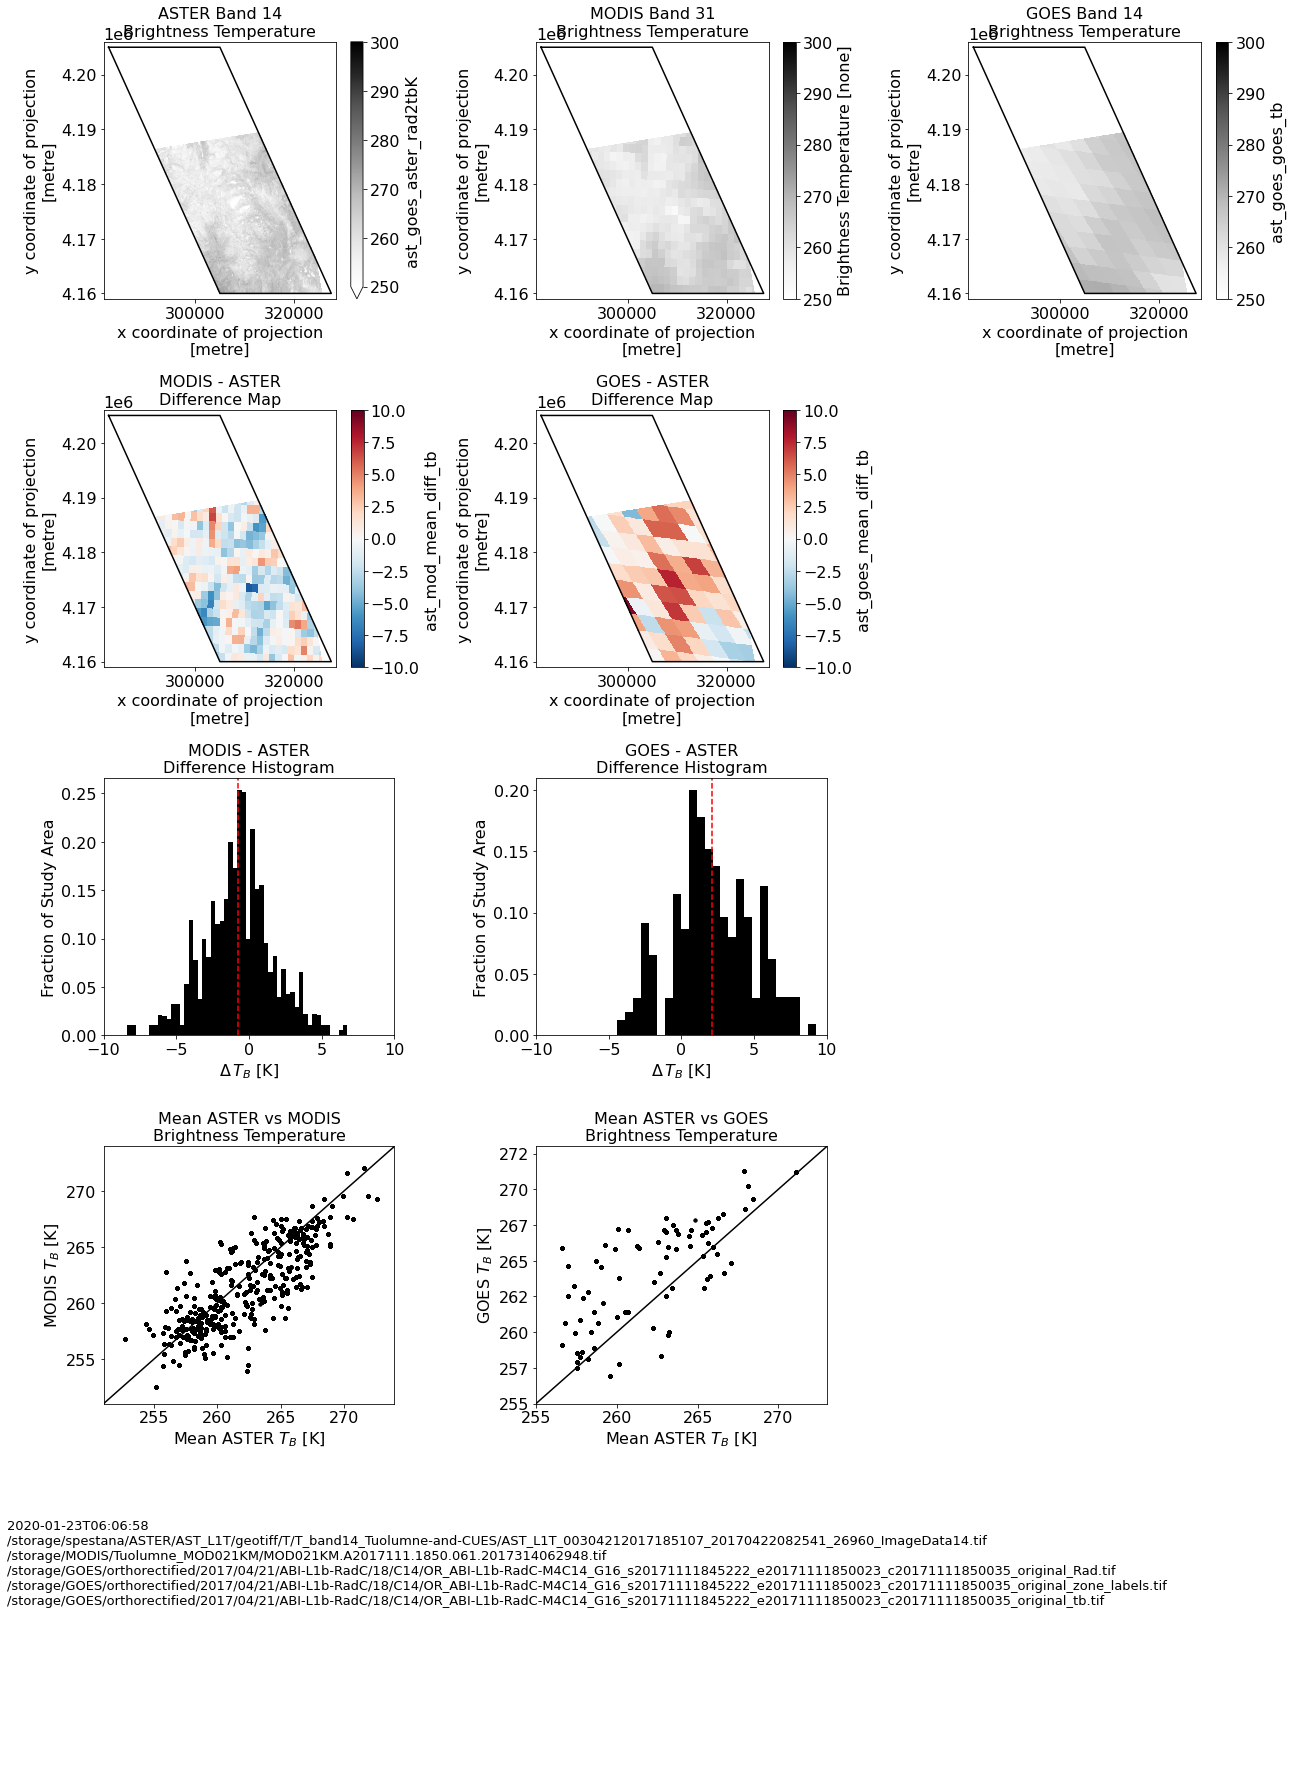

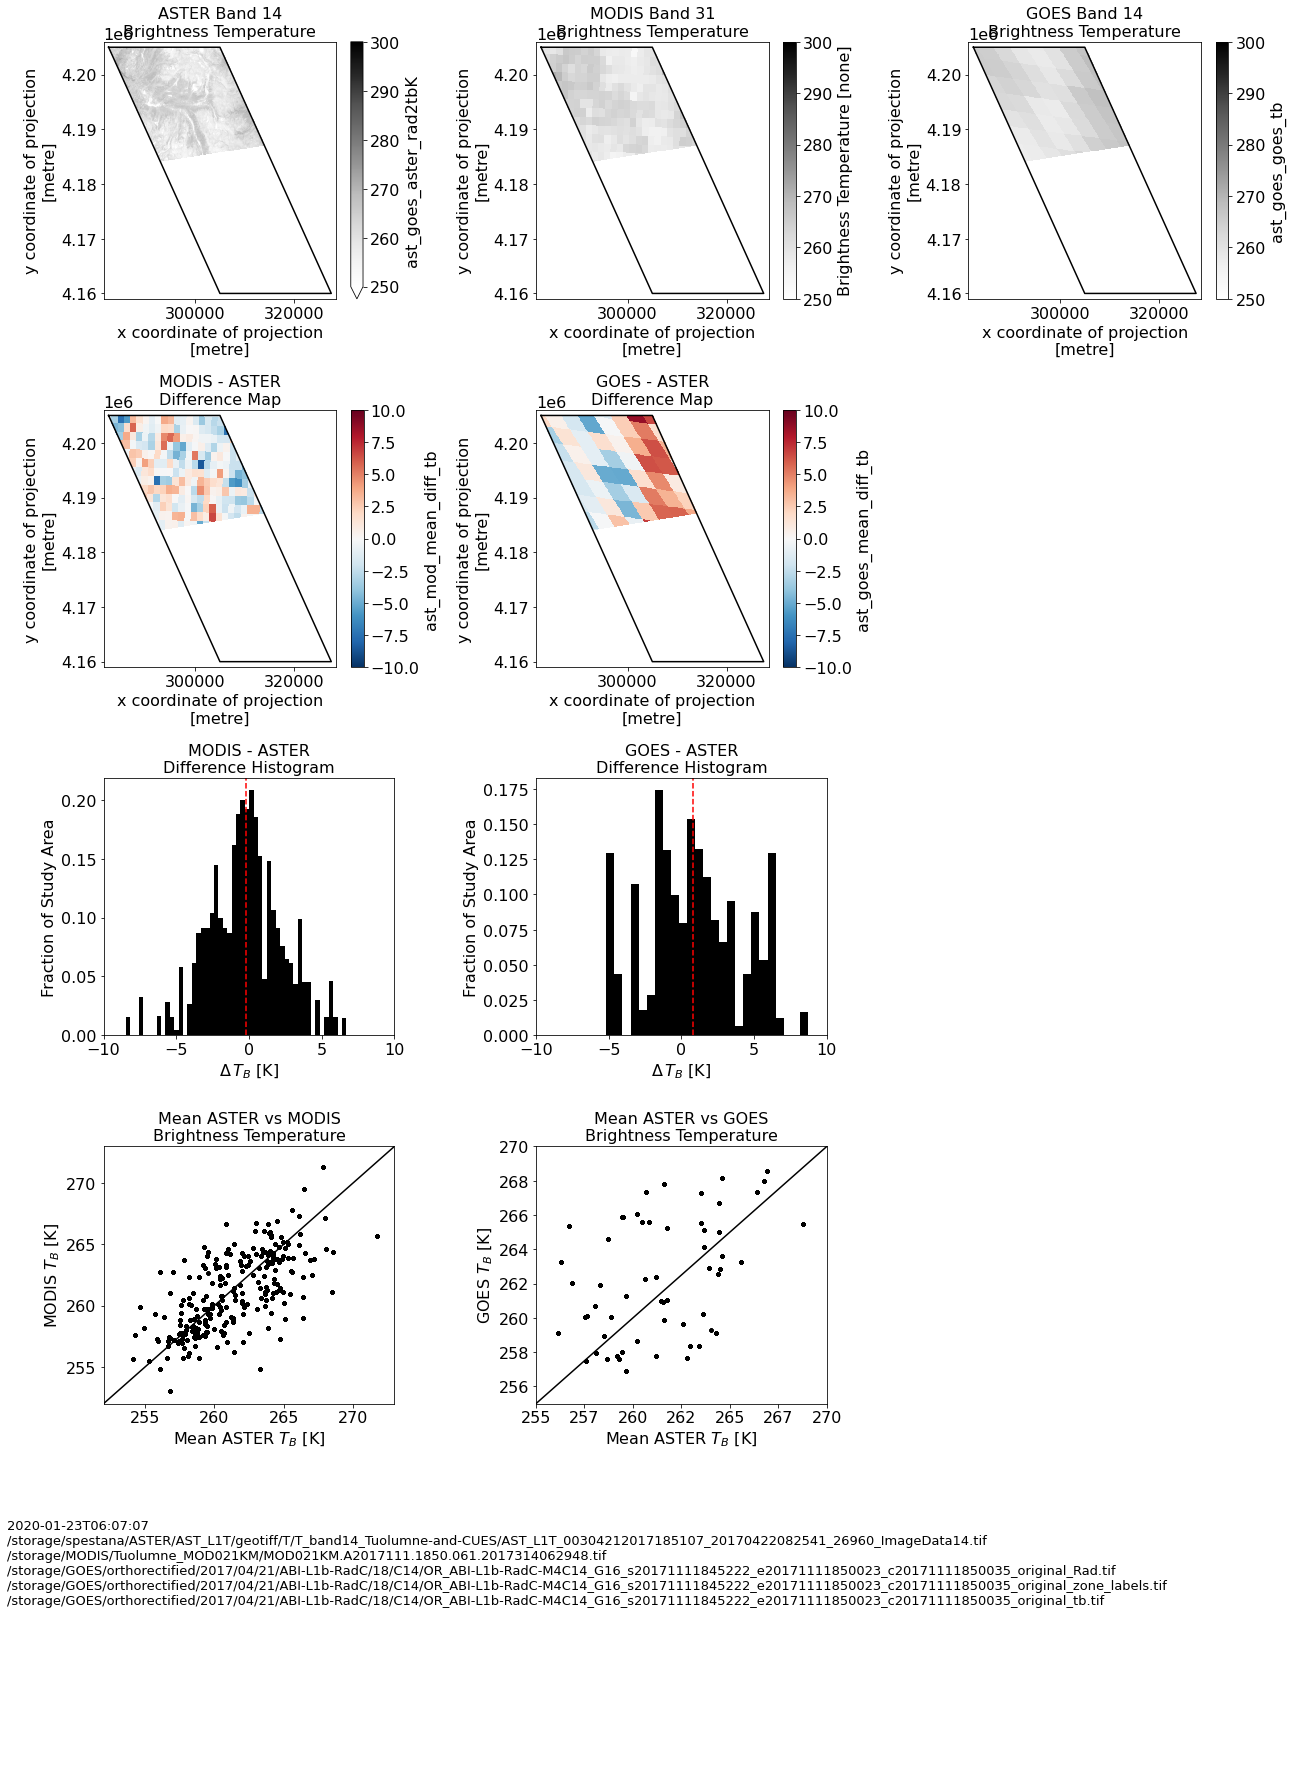

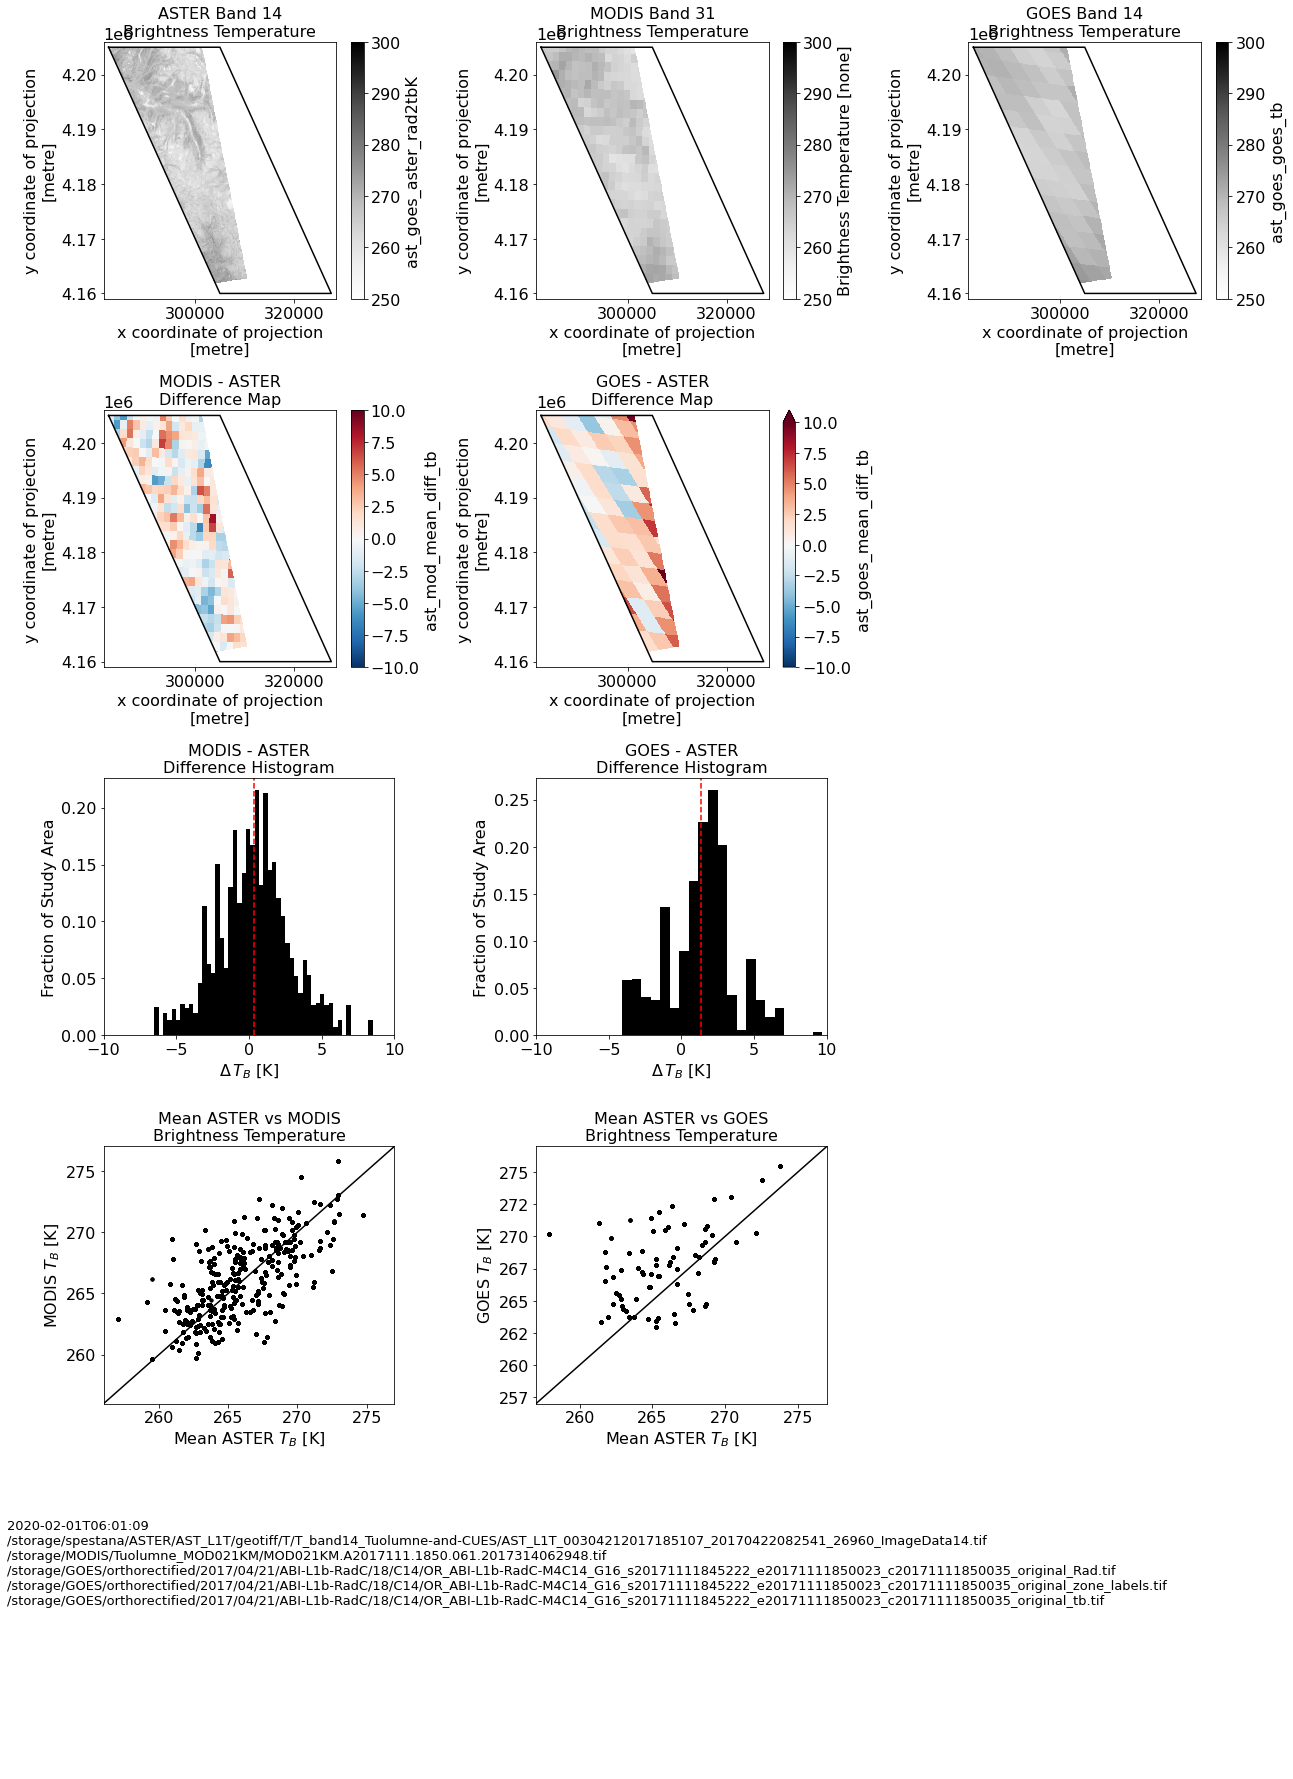

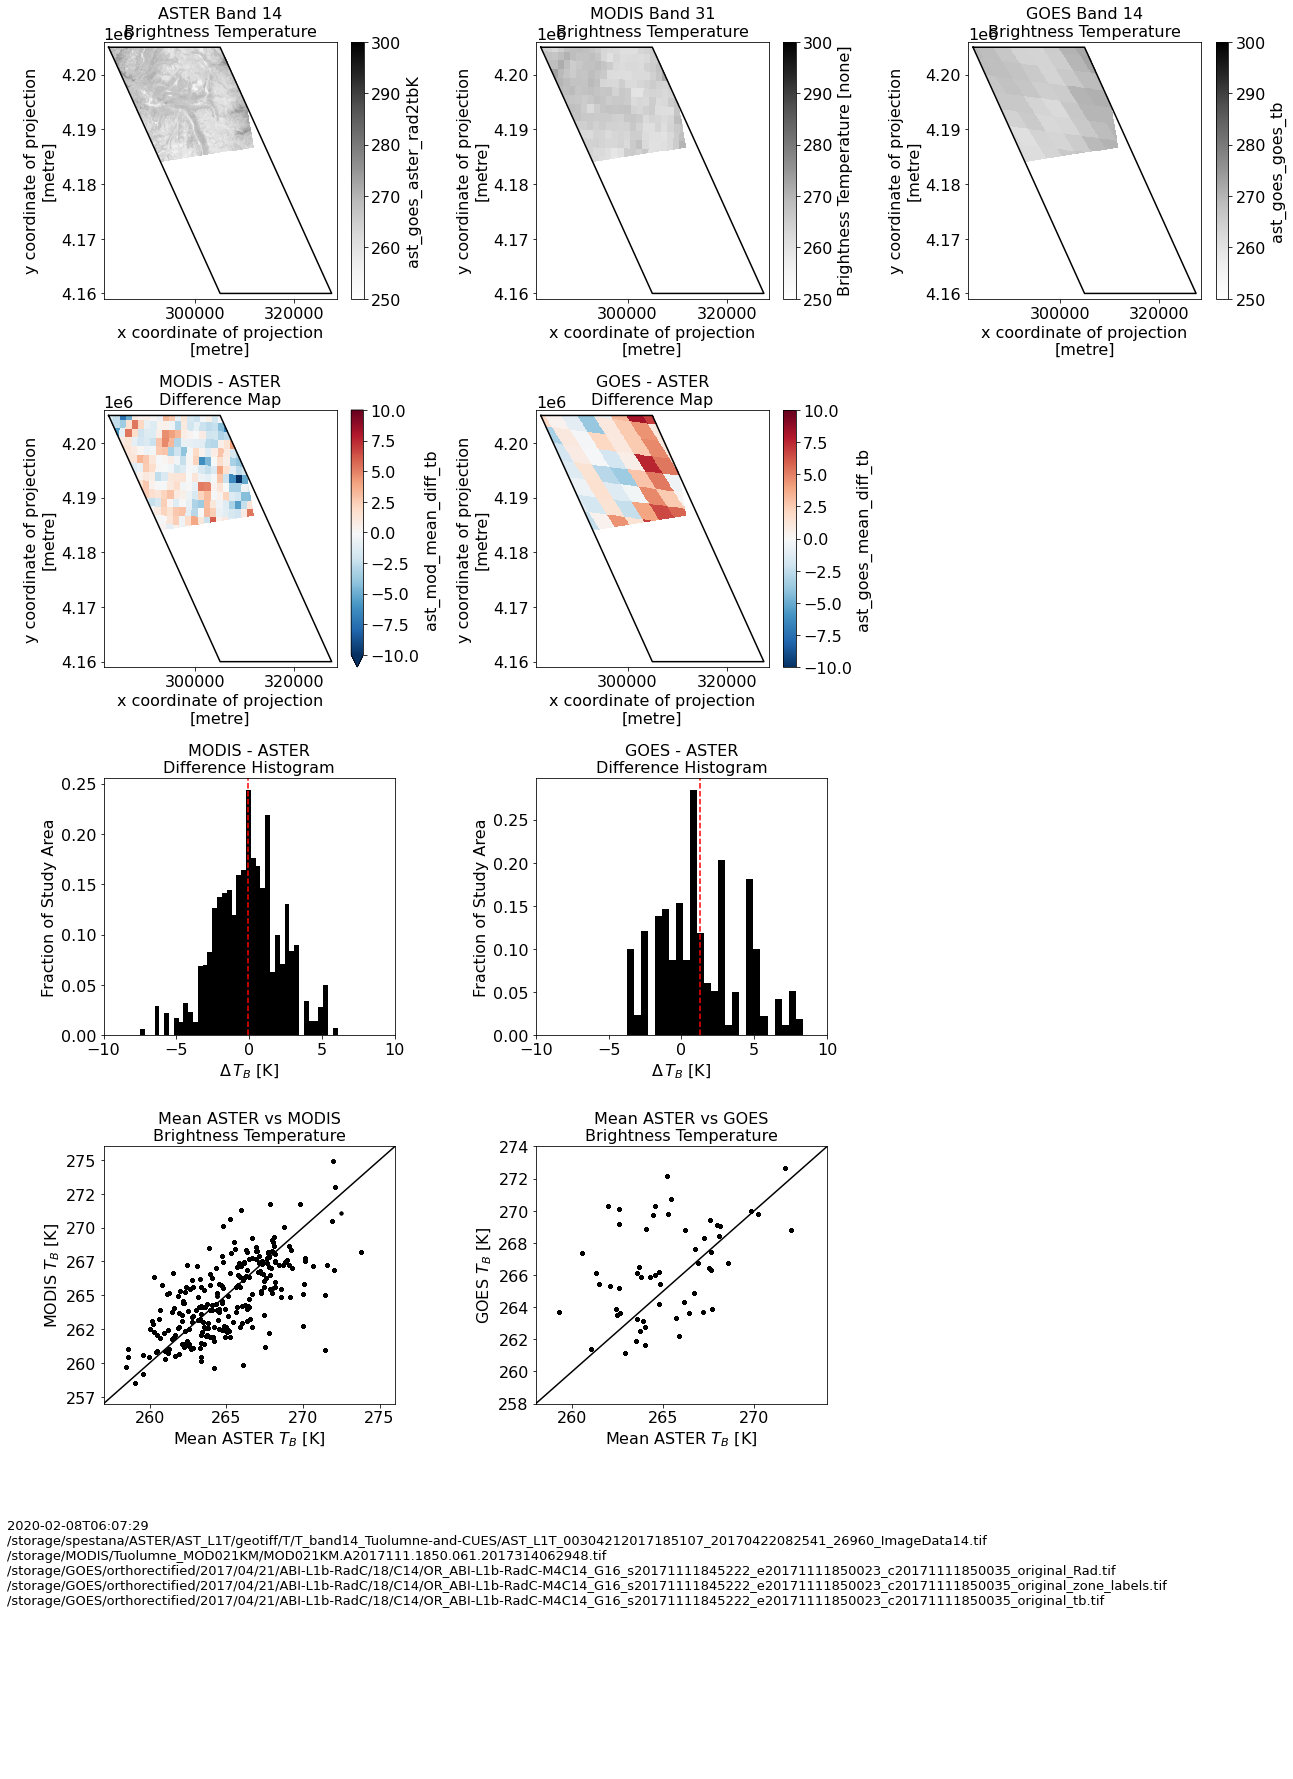

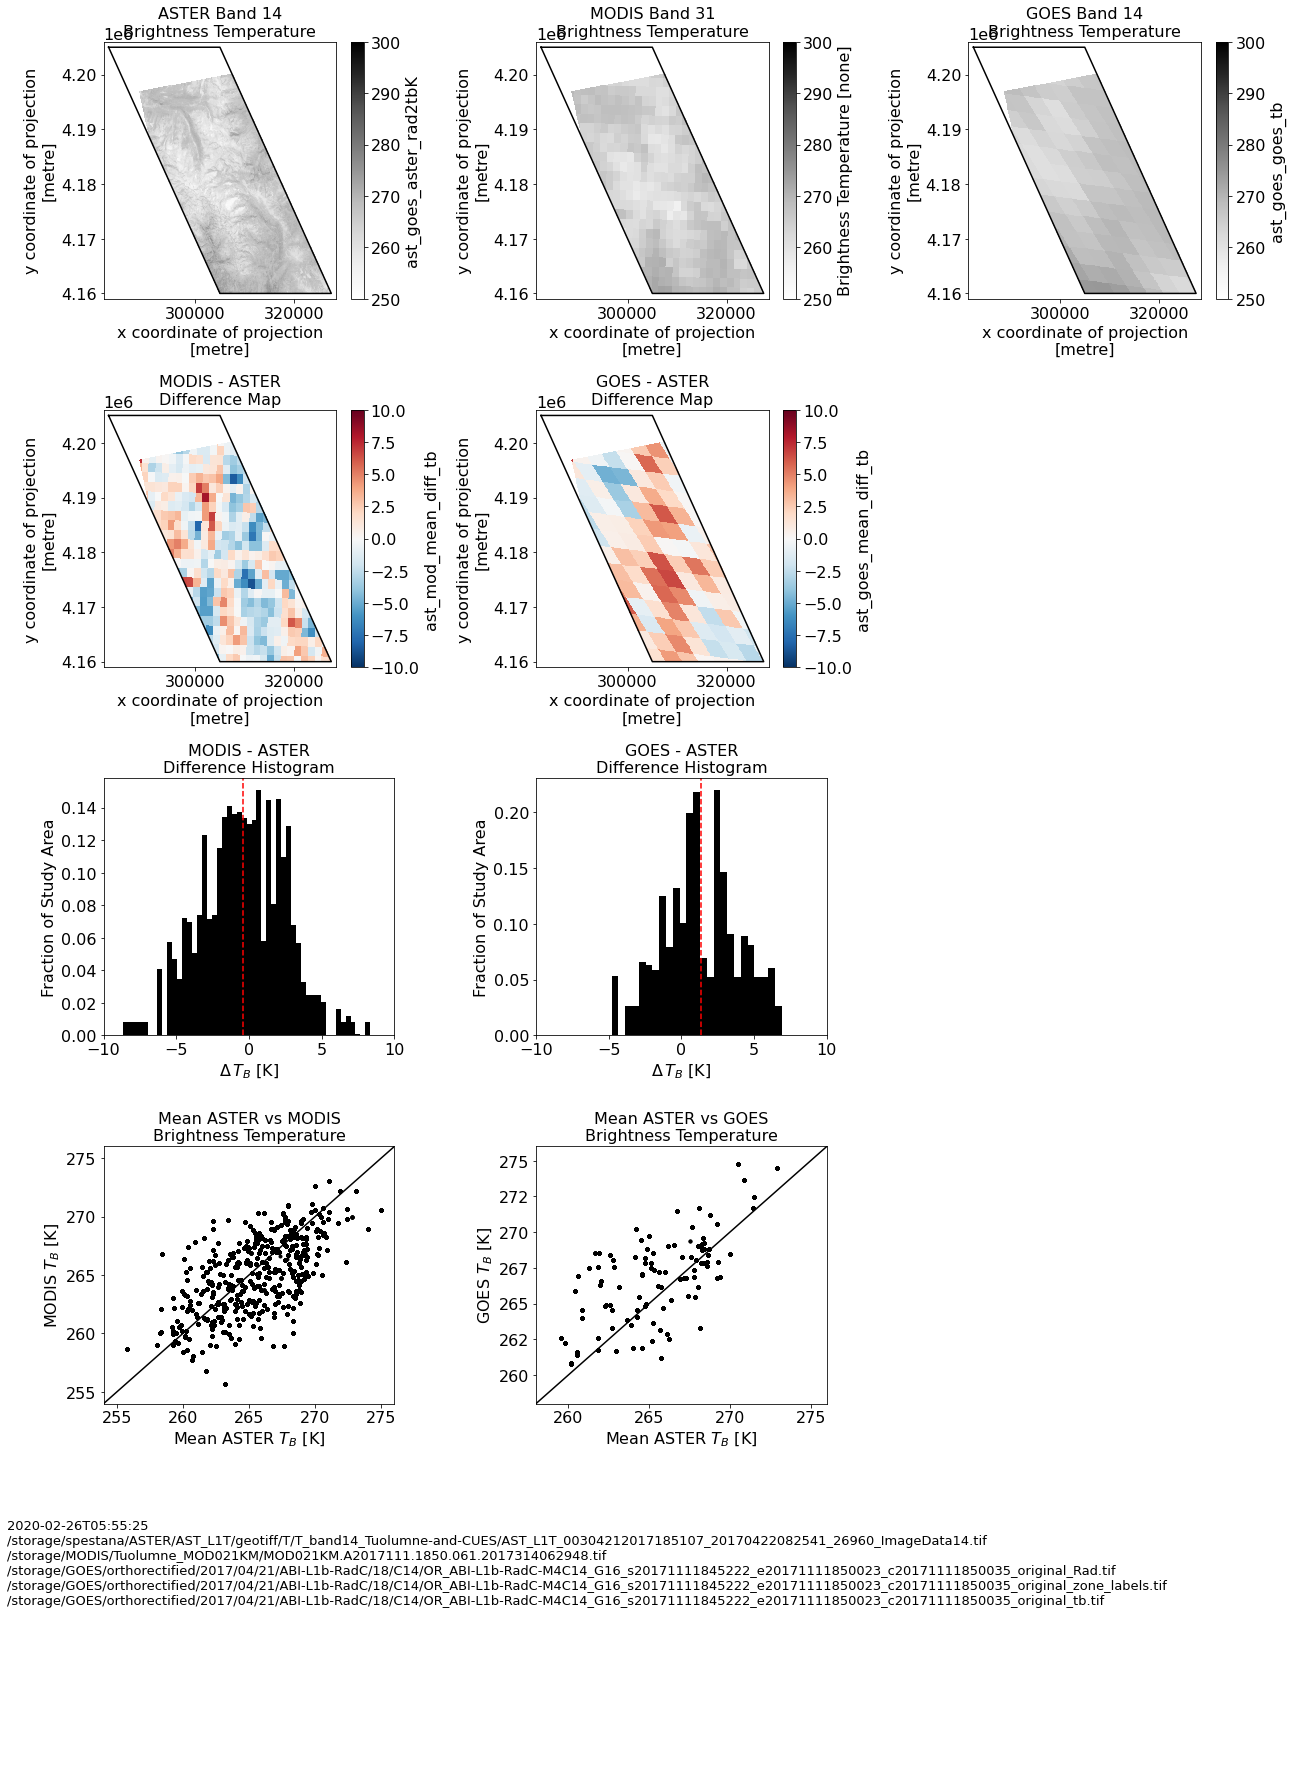

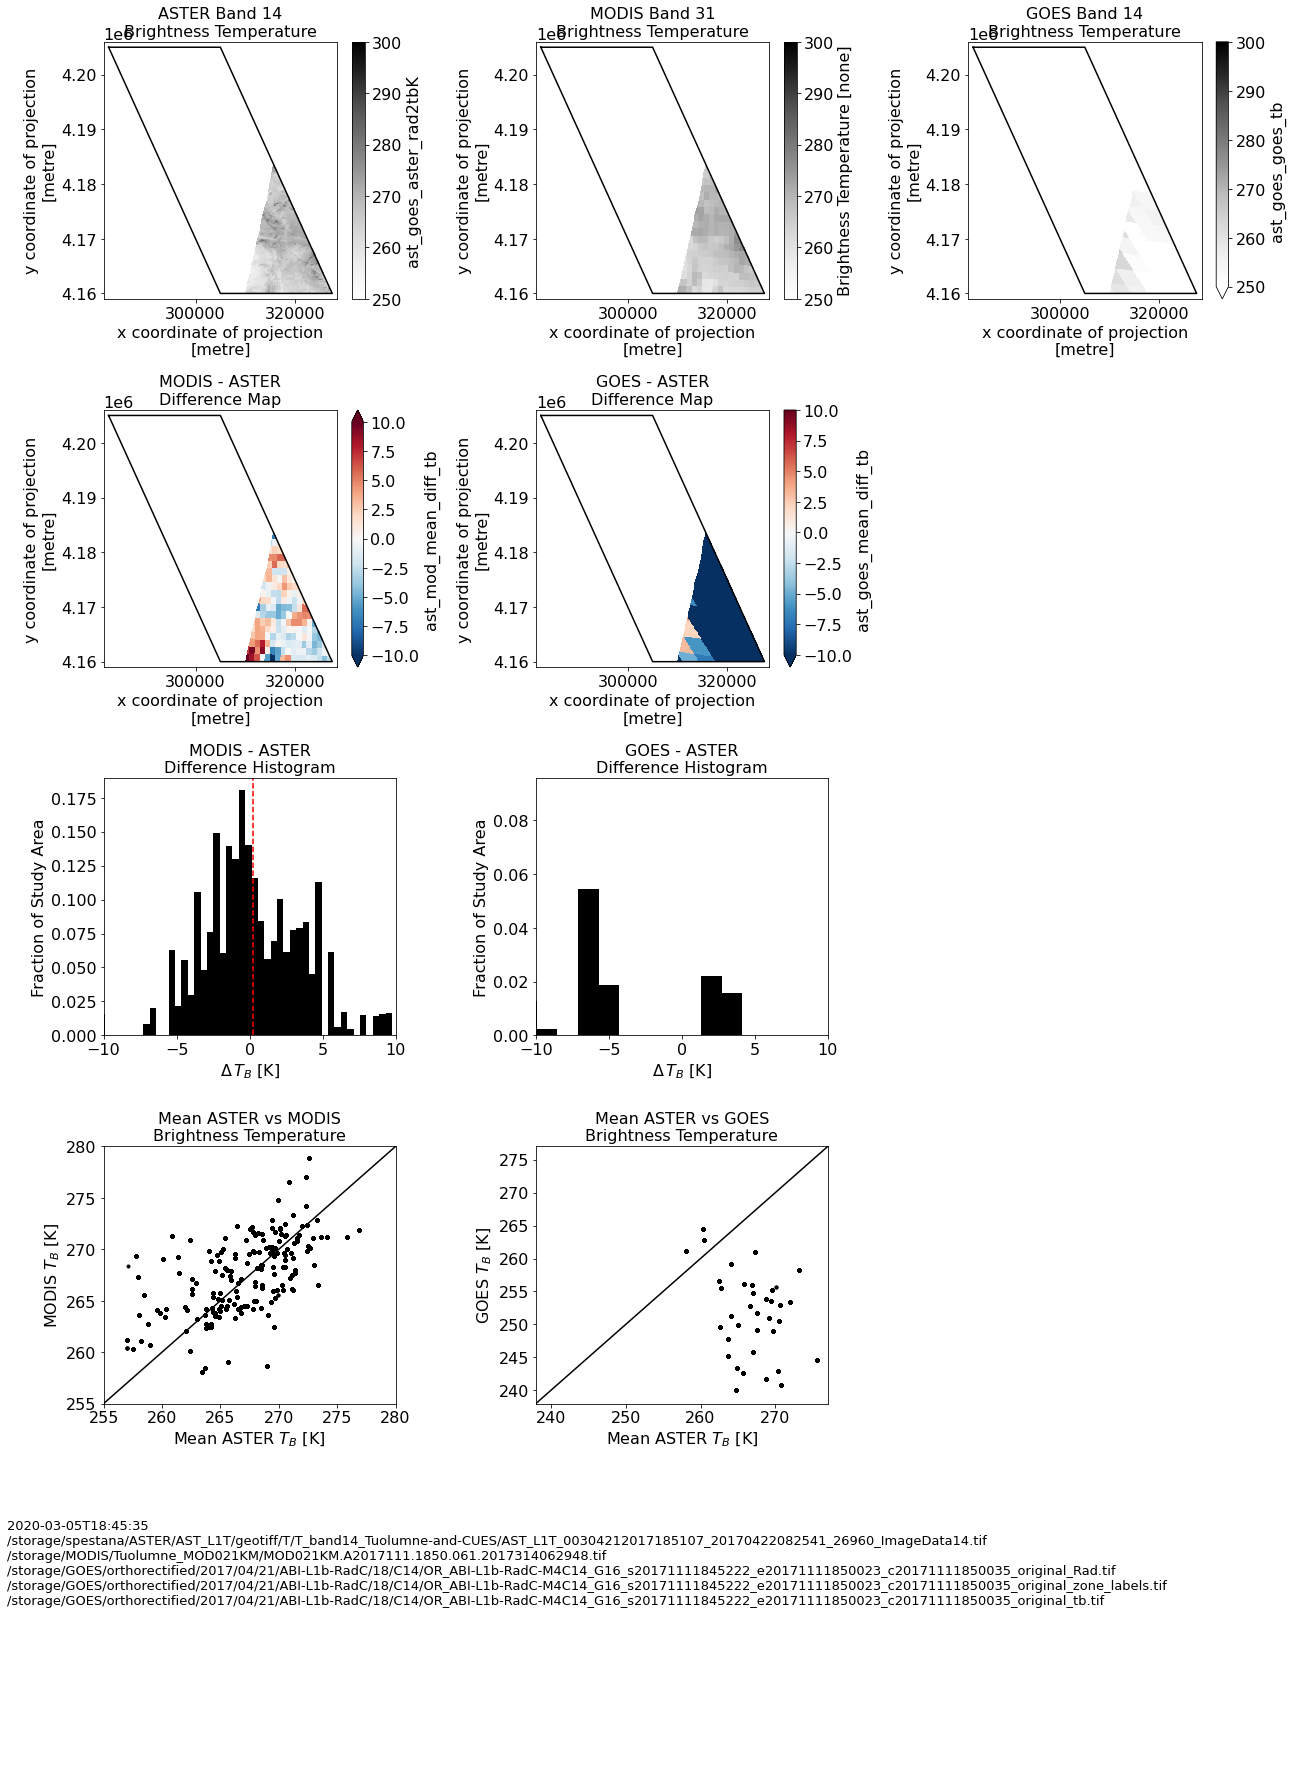

In [11]:
save_figure = True

summary_stats_list = []

for timestep_index in range(len(ds.time)):
    
    # Subset dataset to a single time slice
    _ds = ds.isel(time=timestep_index)
    
    #####################################################################################
    #
    ## Get the CUES and Gaylor Pit temperature observations that were taken at the same time as these satellite images
    #print('Looking for {}'.format(ds.time[timestep_index].values))
    ## CUES
    #_cues_ds = cues_ds.sel(timeUTC=ds.time[timestep_index].values, method='nearest')
    #print('Found for CUES: {}'.format(_cues_ds.timeUTC.values))
    #this_cues_tss = _cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].values
    #this_cues_tair = _cues_ds['Platform temperature; platform temperature/relative humidity; (degrees Celsius)'].values
    ##this_cues_rh = _cues_ds['Platform relative humidity; platform temperature/relative humidity; (percent)'].values
    #
    ## Gaylor Pit (Tuolumne)
    #_tuol_ds = tuol_ds.sel(timeUTC=ds.time[timestep_index].values, method='nearest')
    #print('Found for Gaylor Pit: {}'.format(_tuol_ds.timeUTC.values))
    #this_tuol_tss = _tuol_ds.tss.values
    #this_tuol_tair = _tuol_ds.air_temp_c.values    
    #   
    #####################################################################################
    
    fig = plt.figure(figsize=(18,25), tight_layout=True)
    
    ##### Format figure subplots with subplot2grid:
    ##### ax = subplot2grid((nrows, ncols), (row, col), rowspan, colspan)
    
    nrows = 5
    ncols = 3
    
    ax_aster_tb = plt.subplot2grid((nrows, ncols), (0, 0), 1, 1)
    ax_modis_tb = plt.subplot2grid((nrows, ncols), (0, 1),  1, 1)
    ax_goes_tb = plt.subplot2grid((nrows, ncols), (0, 2), 1, 1)
    
    ax_ast_mod_diff = plt.subplot2grid((nrows, ncols), (1, 0), 1, 1)
    ax_ast_goes_diff = plt.subplot2grid((nrows, ncols), (1, 1), 1, 1)
    blank = plt.subplot2grid((nrows, ncols), (1, 2), 1, 1)
    blank.set_axis_off()
    
    ax_ast_mod_hist = plt.subplot2grid((nrows, ncols), (2, 0), 1, 1)
    ax_ast_goes_hist = plt.subplot2grid((nrows, ncols), (2, 1), 1, 1)
    blank = plt.subplot2grid((nrows, ncols), (2, 2), 1, 1)
    blank.set_axis_off()
    
    ax_ast_mod_1to1 = plt.subplot2grid((nrows, ncols), (3, 0), 1, 1)
    ax_ast_goes_1to1 = plt.subplot2grid((nrows, ncols), (3, 1), 1, 1)
    blank = plt.subplot2grid((nrows, ncols), (3, 2), 1, 1)
    blank.set_axis_off()
        
    blank = plt.subplot2grid((nrows, ncols), (4, 0), 3, 1)
    blank.set_axis_off()
    
    ####################################################################################
    
    
    # make timestamp string for use in figure titles
    timestamp_str = str(_ds.time.values).split('.')[0]
    
    ### Plot the brightness temperature images ###
    # ASTER Tb
    _ds.ast_goes_aster_rad2tbK.plot(ax=ax_aster_tb, add_colorbar=True, cmap='Greys', vmin=250, vmax=300)
    ax_aster_tb.set_title('ASTER Band 14\nBrightness Temperature')
    # MODIS Tb
    _ds.ast_mod_modis_tb.plot(ax=ax_modis_tb, add_colorbar=True, cmap='Greys', vmin=250, vmax=300)
    ax_modis_tb.set_title('MODIS Band 31\nBrightness Temperature')
    # GOES Tb
    _ds.ast_goes_goes_tb.plot(ax=ax_goes_tb, add_colorbar=True, cmap='Greys', vmin=250, vmax=300)
    ax_goes_tb.set_title('GOES Band 14\nBrightness Temperature')

    ### Plot the difference maps for MODIS-ASTER, and GOES-ASTER ###
    _ds.ast_mod_mean_diff_tb.plot(ax=ax_ast_mod_diff, add_colorbar=True, cmap='RdBu_r', vmin=-10, vmax=10)
    ax_ast_mod_diff.set_title('MODIS - ASTER\nDifference Map')
    _ds.ast_goes_mean_diff_tb.plot(ax=ax_ast_goes_diff, add_colorbar=True, cmap='RdBu_r', vmin=-10, vmax=10)
    ax_ast_goes_diff.set_title('GOES - ASTER\nDifference Map')
    
    ### Plot the difference histograms for MODIS-ASTER, and GOES-ASTER ###
    _ds.ast_mod_mean_diff_tb.plot.hist(ax=ax_ast_mod_hist, bins=50, color='k', density=True)
    ax_ast_mod_hist.axvline(_ds.ast_mod_mean_diff_tb.mean(), color='r', linestyle='--') # mean line
    ax_ast_mod_hist.set_title('MODIS - ASTER\nDifference Histogram')
    _ds.ast_goes_mean_diff_tb.plot.hist(ax=ax_ast_goes_hist, bins=25, color='k', density=True)
    ax_ast_goes_hist.axvline(_ds.ast_goes_mean_diff_tb.mean(), color='r', linestyle='--') # mean line
    ax_ast_goes_hist.set_title('GOES - ASTER\nDifference Histogram')
    # Format the axes limits on the histograms
    for ax in [ax_ast_mod_hist, ax_ast_goes_hist]:
        ax.set_xlim(-10,10)
        #ax.set_ylim()
        ax.set_xlabel('$\Delta\,T_B$ [K]')
        ax.set_ylabel('Fraction of Study Area')
    
    ### Plot 1-to-1 for MODIS vs ASTER and GOES vs ASTER ##
    # ASTER and MODIS
    ax_ast_mod_1to1.plot(_ds.ast_mod_mean_rad2tbK, _ds.ast_mod_modis_tb, # aggregated ASTER vs MODIS
                          linestyle='none', marker='.', color='k', alpha=1)
    #ax_ast_mod_1to1.plot(_ds.ast_mod_aster_rad2tbK, _ds.ast_mod_modis_tb, # subpixel ASTER vs MODIS
    #                      linestyle='none', marker='.', color='k', alpha=1)
    ax_ast_mod_1to1.set_title('Mean ASTER vs MODIS\nBrightness Temperature')
    ax_ast_mod_1to1.set_xlabel('Mean ASTER $T_B$ [K]')
    ax_ast_mod_1to1.set_ylabel('MODIS $T_B$ [K]')
    # ASTER and GOES
    ax_ast_goes_1to1.plot(_ds.ast_goes_mean_rad2tbK, _ds.ast_goes_goes_tb, # aggregated ASTER vs GOES
                          linestyle='none', marker='.', color='k', alpha=1)
    #ax_ast_goes_1to1.plot(_ds.ast_goes_aster_rad2tbK, _ds.ast_goes_goes_tb, # subpixel ASTER vs GOES
    #                      linestyle='none', marker='.', color='k', alpha=1)
    ax_ast_goes_1to1.set_title('Mean ASTER vs GOES\nBrightness Temperature')
    ax_ast_goes_1to1.set_xlabel('Mean ASTER $T_B$ [K]')
    ax_ast_goes_1to1.set_ylabel('GOES $T_B$ [K]')
    
    ### Summary Stats ###
    summary_stats_ast_mod = summary_stats(_ds.ast_mod_mean_rad2tbK.values.ravel(), _ds.ast_mod_modis_tb.values.ravel())
    summary_stats_ast_subpx_mod = summary_stats(_ds.ast_mod_aster_rad2tbK.values.ravel(), _ds.ast_mod_modis_tb.values.ravel())
    summary_stats_ast_goes = summary_stats(_ds.ast_goes_mean_rad2tbK.values.ravel(), _ds.ast_goes_goes_tb.values.ravel())
    summary_stats_ast_subpx_goes = summary_stats(_ds.ast_goes_aster_rad2tbK.values.ravel(), _ds.ast_goes_goes_tb.values.ravel())
    # compile summary stats into a pandas dataframe
    # Update key names
    _summary_stats_ast_mod = { 'ast_mod_'+k: v for k, v in summary_stats_ast_mod.items() }
    _summary_stats_ast_subpx_mod = { 'ast_subpx_mod_'+k: v for k, v in summary_stats_ast_subpx_mod.items() }
    _summary_stats_ast_goes = { 'ast_goes_'+k: v for k, v in summary_stats_ast_goes.items() }
    _summary_stats_ast_subpx_goes = { 'ast_subpx_goes_'+k: v for k, v in summary_stats_ast_subpx_goes.items() }
    # merge all three dictionaries together with some other data values
    summary_stats_dict = {'time' : _ds.time.values,
                          'aster_rad_filepath': _ds.attrs['aster_rad_filepath'],
                          'modis_rad_filepath': _ds.attrs['modis_rad_filepath'],
                          'goes_rad_filepath': _ds.attrs['goes_rad_filepath'],
                          'goes_zones_filepath': _ds.attrs['goes_zones_filepath'],
                          'goes_tb_filepath': _ds.attrs['goes_tb_filepath'],
                          **_summary_stats_ast_mod, **_summary_stats_ast_subpx_mod,
                          **_summary_stats_ast_goes, **_summary_stats_ast_subpx_goes}    
    
        
    # append summary stats to list of all summary stats
    summary_stats_list.append(summary_stats_dict)
    

    
    # 1-to-1 plots and axes formatting
    for ax_1_to_1 in [ax_ast_mod_1to1, ax_ast_goes_1to1]:
        # get max and min values for axes
        (ax_min, ax_max) = (int(np.floor( np.min( [ax_1_to_1.get_xlim()[0], ax_1_to_1.get_ylim()[0]] ) )), 
                            int(np.ceil( np.max( [ax_1_to_1.get_xlim()[1], ax_1_to_1.get_ylim()[1]] ) )) )
        # add 1-to-1 line
        ax_1_to_1.plot([ax_min,ax_max],[ax_min,ax_max],'k-')
        # set axes limits
        ax_1_to_1.set_xlim((ax_min,ax_max))
        ax_1_to_1.set_ylim((ax_min,ax_max))
        ax_1_to_1.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
        ax_1_to_1.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
    
    ## Add Gaylor Pit and CUES temperatures to 1-to-1 plots, along the 1-to-1 line:
    #for ax_1_to_1 in [ax_ast_mod_1to1, ax_ast_goes_1to1]:
    #    ax_1_to_1.plot(this_cues_tss+273.15, this_cues_tss+273.15, color='tab:blue', linestyle='none', marker='P', markersize=12, label='CUES $T_{ss}$')
    #    ax_1_to_1.plot(this_tuol_tss+273.15, this_tuol_tss+273.15, color='tab:blue', linestyle='none', marker='X', markersize=12, label='Gaylor Pit $T_{ss}$')
    #    ax_1_to_1.plot(this_cues_tair+273.15, this_cues_tair+273.15, color='tab:green', linestyle='none', marker='P', markersize=12, label='CUES $T_a$')
    #    ax_1_to_1.plot(this_tuol_tair+273.15, this_tuol_tair+273.15, color='tab:green', linestyle='none', marker='X', markersize=12, label='Gaylor Pit $T_a$')
    #    ax_1_to_1.legend()
        
    # Plot an outline of the study area, and Gaylor Pit and CUES markers on the map axes
    for ax in [ax_aster_tb, ax_modis_tb, ax_goes_tb, ax_ast_mod_diff, ax_ast_goes_diff]:
        ax.set_xlim((utm_e_UL-1000,utm_e_LR+1000))
        ax.set_ylim((utm_n_LR-1000,utm_n_UL+1000))
        
        #ax.scatter(296649, 4195210, 
        #                    marker='o', 
        #                    edgecolor='k', 
        #                    facecolor='w', 
        #                    s=100, 
        #                    label='Gaylor Pit')
        #ax.scatter(320971, 4168153, 
        #                    marker='o', 
        #                    edgecolor='k', 
        #                    facecolor='w', 
        #                    s=100, 
        #                    label='CUES')
        ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
                         [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
                         linestyle='-', color='k')
        
        

    # add title at bottom of figure    
    fig.suptitle('{}\n{}\n{}\n{}\n{}\n{}'.format(timestamp_str,
                                         _ds.attrs['aster_rad_filepath'],
                                         _ds.attrs['modis_rad_filepath'],
                                         _ds.attrs['goes_rad_filepath'],
                                         _ds.attrs['goes_zones_filepath'],
                                         _ds.attrs['goes_tb_filepath']),
                x=0, y=0.15, ha='left', fontsize=13);
    
    filename_friendly_timestamp_str = timestamp_str.replace(':','')
    if save_figure == True:
        #plt.savefig('./images/ASTER_MODIS_GOES/upscaled_comparisons/ASTER_MODIS_GOES_orthorectified_{}.jpg'.format(filename_friendly_timestamp_str))
        plt.savefig('./images/ASTER_MODIS_GOES/upscaled_comparisons/ASTER_MODIS_GOES_original_{}.jpg'.format(filename_friendly_timestamp_str))

#### Make pandas dataframe from summary stats dictionaries
summary_stats_df = pd.DataFrame(summary_stats_list)
# save out to csv file
#summary_stats_df.to_csv('goes_modis_aster_orthorectified_tb_summary_stats.csv')
summary_stats_df.to_csv('goes_modis_aster_original_tb_summary_stats.csv')